In [1]:
import sys
import os
import gc
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import textwrap
from scipy.stats import gaussian_kde

# Add the root directory of your project to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.core.config import settings
from src.db.db import Database
from src.utils.utils import timing
from analysis.master_thesis_philipp_config import poi_dicts

In [26]:
class EDA:
    def __init__(self, db, db_rd=None):
        self.db = db
        self.db_rd = db_rd
    
    def fetch_data_in_chunks(self, poi_category, transport_mode, chunksize=100000):
        """Fetch data from the database in chunks to avoid memory overload."""
        table_name = f"{poi_category}_{transport_mode}"
        sql_query = f"SELECT * FROM {table_name}"
        try:
            chunk_iter = pd.read_sql(sql_query, self.db.return_sqlalchemy_engine(), chunksize=chunksize)
            df_list = []
            for chunk in chunk_iter:
                optimized_chunk = self.optimize_dataframe(chunk)
                df_list.append(optimized_chunk)
            df = pd.concat(df_list, ignore_index=True)  # Combine all chunks into a single DataFrame
            return df
        except Exception as e:
            print(f"Error fetching data from {table_name}: {e}")
            return pd.DataFrame()  # Return an empty DataFrame on error


    def optimize_dataframe(self, df, columns_to_exclude=None):
        """Optimize the dataframe for memory efficiency and handle specific column types."""
        if columns_to_exclude is None:
            columns_to_exclude = []

        # Exclude unwanted columns upfront
        df = df.drop(columns=columns_to_exclude, errors='ignore')

        # Convert specific columns to 'category' type if they exist
        if 'regiostar_17' in df.columns:
            df['regiostar_17'] = df['regiostar_17'].astype('category')
        if 'objart' in df.columns:
            df['objart'] = df['objart'].astype('category')

        # Optimize other object columns by converting them to 'category'
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = df[col].astype('category')

        # Apply rounding and conversion to specific float columns
        for col in df.select_dtypes(include=['float']).columns:
            if 'closest_average' in col.lower() or 'gaussian' in col.lower():
                df[col] = df[col].round(0).astype(pd.Int64Dtype())  # Round and then convert to int
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')  # Downcast all other floats

        return df

    def plot_filtered_correlation_matrix(self, df, corr_threshold=0.3, columns_to_exclude=None, standardize=True):
        """
        Generate a filtered correlation matrix that includes one-hot encoded categorical variables.
        Exclude columns and rows where no correlation meets the threshold.
        """
        if columns_to_exclude is None:
            columns_to_exclude = []

        # Drop excluded columns
        df = df.drop(columns=columns_to_exclude, errors='ignore')

        # Identify categorical columns and one-hot encode them
        categorical_columns = df.select_dtypes(include=['category']).columns.tolist()
        df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

        # Standardize numeric columns if required
        numeric_columns = df_encoded.select_dtypes(include=[np.number]).columns
        if standardize:
            df_encoded[numeric_columns] = (df_encoded[numeric_columns] - df_encoded[numeric_columns].mean()) / df_encoded[numeric_columns].std()

        # Generate correlation matrix
        corr_matrix = df_encoded.corr()

        # Apply correlation threshold, excluding the diagonal
        mask = corr_matrix.abs() >= corr_threshold
        np.fill_diagonal(mask.values, False)  # Exclude diagonal correlations

        # Filter out rows and columns that do not meet the threshold
        rows_to_keep = mask.any(axis=1)
        cols_to_keep = mask.any(axis=0)
        corr_matrix_filtered = corr_matrix.loc[rows_to_keep, cols_to_keep]

        # Check if there are any correlations left after filtering
        if corr_matrix_filtered.empty:
            print(f"No correlations above threshold of {corr_threshold}.")
            return

        # Plot the filtered correlation matrix
        plt.figure(figsize=(max(10, len(corr_matrix_filtered.columns)), max(8, len(corr_matrix_filtered.index))))
        sns.heatmap(corr_matrix_filtered, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
        plt.title(f'Filtered Correlation Matrix (Corr. Threshold = {corr_threshold})', fontsize=16)
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()
        plt.close()

    def plot_combined_info(self, df, exclude_outliers=False, outlier_threshold=0):
        """Plot descriptive statistics, box plots, and density estimates for the entire dataset and across RegioStaR levels."""
        
        # Define all numeric variables to compare
        variables_to_compare = df.select_dtypes(include=[np.number]).columns.tolist()

        # Define RegioStaR levels
        regiostar_levels = ['2', '4', '7', 'Gem7', 'Gem5', '17']

        # Define the RegioStaR mapping
        regiostar_mapping = {
            '2': {111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 121: 1, 123: 1, 124: 1, 125: 1, 211: 2, 213: 2, 214: 2, 215: 2, 221: 2, 223: 2, 224: 2, 225: 2},
            '4': {111: 11, 112: 11, 113: 11, 114: 11, 115: 11, 121: 12, 123: 12, 124: 12, 125: 12, 211: 21, 213: 21, 214: 21, 215: 21, 221: 22, 223: 22, 224: 22, 225: 22},
            '7': {111: 71, 112: 72, 113: 73, 114: 73, 115: 74, 121: 72, 123: 73, 124: 73, 125: 74, 211: 75, 213: 76, 214: 76, 215: 77, 221: 75, 223: 76, 224: 76, 225: 77},
            'Gem7': {111: 1, 112: 3, 113: 5, 114: 6, 115: 7, 121: 2, 123: 5, 124: 6, 125: 7, 211: 4, 213: 5, 214: 6, 215: 7, 221: 4, 223: 5, 224: 6, 225: 7},
            'Gem5': {111: 1, 112: 2, 113: 3, 114: 4, 115: 5, 121: 2, 123: 3, 124: 4, 125: 5, 211: 3, 213: 3, 214: 4, 215: 5, 221: 3, 223: 3, 224: 4, 225: 5},
            '17': {111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 121: 121, 123: 123, 124: 124, 125: 125, 211: 211, 213: 213, 214: 214, 215: 215, 221: 221, 223: 223, 224: 224, 225: 225}
        }

        # ---------------- Overall Statistics (One Table) ----------------
        # Calculate overall descriptive statistics for the entire dataset
        overall_stats = df[variables_to_compare].describe().T
        overall_stats['Skewness'] = df[variables_to_compare].skew()
        overall_stats['Kurtosis'] = df[variables_to_compare].kurtosis()

        # Display overall table as a plot
        plt.figure(figsize=(14, 8))
        plt.title('Overall Descriptive Statistics for Entire Dataset')
        plt.table(cellText=overall_stats.round(2).values, colLabels=overall_stats.columns, rowLabels=overall_stats.index, loc='center')
        plt.axis('off')
        plt.show()
        plt.close()

        # ---------------- Per RegioStaR Statistics ----------------
        # Map RegioStaR 17 to other levels for statistics
        for level in regiostar_levels:
            df[f'regiostar_{level}'] = df['regiostar_17'].map(regiostar_mapping[level])

        # Initialize dictionary to store precomputed density estimates
        density_data = {level: {} for level in regiostar_levels}

        # Function to filter outliers
        def filter_outliers(data, threshold=1.5):
            q1 = np.percentile(data, 25)
            q3 = np.percentile(data, 75)
            iqr = q3 - q1
            lower_bound = q1 - threshold * iqr
            upper_bound = q3 + threshold * iqr
            return data[(data >= lower_bound) & (data <= upper_bound)]

        # Compute density estimates for each numeric column and RegioStaR level
        for level in regiostar_levels:
            for variable in variables_to_compare:
                if variable not in density_data[level]:
                    density_data[level][variable] = {}

                categories = df[f'regiostar_{level}'].dropna().unique()
                for cat in categories:
                    data = df[df[f'regiostar_{level}'] == cat][variable].dropna().values
                    # Convert to standard numpy types
                    data = data.astype(np.float64)  # Convert to float64
                    if exclude_outliers:
                        data = filter_outliers(data, threshold=outlier_threshold)  # Filter out outliers if the option is enabled
                    data = data[np.isfinite(data)]  # Filter out non-numeric and NaN values
                    if len(data) > 1 and np.issubdtype(data.dtype, np.number):
                        kde = gaussian_kde(data)  # Compute density estimate
                        density_data[level][variable][cat] = kde
                        
        # Loop through RegioStaR levels and create tables, box plots, and violin plots for each variable
        for level in regiostar_levels:
            for variable in variables_to_compare:
                # Calculate descriptive statistics for the variable across RegioStaR levels
                stats = df.groupby(f'regiostar_{level}')[variable].describe()
                skewness = df.groupby(f'regiostar_{level}')[variable].apply(pd.Series.skew).rename('Skewness')
                kurtosis = df.groupby(f'regiostar_{level}')[variable].apply(pd.Series.kurtosis).rename('Kurtosis')
                stats = pd.concat([stats, skewness, kurtosis], axis=1)

                # Display the table as a plot
                plt.figure(figsize=(10, 6))
                plt.title(f'Statistics for {variable} by RegioStaR {level}')
                plt.table(cellText=stats.round(2).values, colLabels=stats.columns, rowLabels=stats.index, loc='center')
                plt.axis('off')
                plt.show()
                plt.close()

                # Display a box plot for the current variable and RegioStaR level
                plt.figure(figsize=(10, 6))
                sns.boxplot(x=f'regiostar_{level}', y=variable, data=df)
                plt.title(f'{variable} distribution by RegioStaR {level}')
                plt.xlabel(f'RegioStaR {level}')
                plt.ylabel(variable)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
                plt.close()

                # Optimized Violin Plot for RegioStaR Levels
                categories = df[f'regiostar_{level}'].dropna().unique()  # Get unique categories
                if pd.api.types.is_categorical_dtype(categories):
                    categories = list(categories)  # Convert to list for sorting
                categories = sorted(categories)  # Sort categories to keep a consistent order

                # Ensure each dataset is a valid 1D numeric array
                data = [np.array(df[df[f'regiostar_{level}'] == cat][variable].dropna().values).astype(np.float64) for cat in categories]
                valid_data = [d for d in data if d.ndim == 1 and len(d) > 1 and np.issubdtype(d.dtype, np.number)]

                print(f"Preparing to plot violin plot for {variable} by RegioStaR {level}. Valid data lengths: {[len(d) for d in valid_data]}")  # Debugging statement

                if len(valid_data) > 0:  # Only plot if valid data is available
                    try:
                        plt.figure(figsize=(12, 7))
                        plt.violinplot(valid_data, showmeans=True, showmedians=True)
                        plt.title(f'Distribution of {variable} by RegioStaR {level}')
                        plt.xlabel(f'RegioStaR {level}')
                        plt.ylabel(variable)
                        plt.xticks(ticks=np.arange(1, len(categories) + 1), labels=categories, rotation=45)
                        plt.grid(True, axis='y')
                        plt.tight_layout()
                        plt.show()
                        plt.close()
                        print(f"Violin plot generated for {variable} by RegioStaR {level}")  # Debugging statement
                    except Exception as e:
                        print(f"Violin plot could not be generated for {variable} by RegioStaR {level}: {e}")
                    
    # def plot_combined_info(self, df):
    #     """Plot descriptive statistics, box plots, and density estimates for the entire dataset and across RegioStaR levels."""
        
    #     # Define all numeric variables to compare
    #     variables_to_compare = df.select_dtypes(include=[np.number]).columns.tolist()

    #     # Define RegioStaR levels
    #     regiostar_levels = ['2', '4', '7', 'Gem7', 'Gem5', '17']

    #     # Define the RegioStaR mapping
    #     regiostar_mapping = {
    #         '2': {111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 121: 1, 123: 1, 124: 1, 125: 1, 211: 2, 213: 2, 214: 2, 215: 2, 221: 2, 223: 2, 224: 2, 225: 2},
    #         '4': {111: 11, 112: 11, 113: 11, 114: 11, 115: 11, 121: 12, 123: 12, 124: 12, 125: 12, 211: 21, 213: 21, 214: 21, 215: 21, 221: 22, 223: 22, 224: 22, 225: 22},
    #         '7': {111: 71, 112: 72, 113: 73, 114: 73, 115: 74, 121: 72, 123: 73, 124: 73, 125: 74, 211: 75, 213: 76, 214: 76, 215: 77, 221: 75, 223: 76, 224: 76, 225: 77},
    #         'Gem7': {111: 1, 112: 3, 113: 5, 114: 6, 115: 7, 121: 2, 123: 5, 124: 6, 125: 7, 211: 4, 213: 5, 214: 6, 215: 7, 221: 4, 223: 5, 224: 6, 225: 7},
    #         'Gem5': {111: 1, 112: 2, 113: 3, 114: 4, 115: 5, 121: 2, 123: 3, 124: 4, 125: 5, 211: 3, 213: 3, 214: 4, 215: 5, 221: 3, 223: 3, 224: 4, 225: 5},
    #         '17': {111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 121: 121, 123: 123, 124: 124, 125: 125, 211: 211, 213: 213, 214: 214, 215: 215, 221: 221, 223: 223, 224: 224, 225: 225}
    #     }

    #     # ---------------- Overall Statistics (One Table) ----------------
    #     # Calculate overall descriptive statistics for the entire dataset
    #     overall_stats = df[variables_to_compare].describe().T
    #     overall_stats['Skewness'] = df[variables_to_compare].skew()
    #     overall_stats['Kurtosis'] = df[variables_to_compare].kurtosis()

    #     # Display overall table as a plot
    #     plt.figure(figsize=(14, 8))
    #     plt.title('Overall Descriptive Statistics for Entire Dataset')
    #     plt.table(cellText=overall_stats.round(2).values, colLabels=overall_stats.columns, rowLabels=overall_stats.index, loc='center')
    #     plt.axis('off')
    #     plt.show()
    #     plt.close()

    #     # ---------------- Per RegioStaR Statistics ----------------
    #     # Map RegioStaR 17 to other levels for statistics
    #     for level in regiostar_levels:
    #         df[f'regiostar_{level}'] = df['regiostar_17'].map(regiostar_mapping[level])

    #     # Initialize dictionary to store precomputed density estimates
    #     density_data = {level: {} for level in regiostar_levels}

    #     # Compute density estimates for each numeric column and RegioStaR level
    #     for level in regiostar_levels:
    #         for variable in variables_to_compare:
    #             if variable not in density_data[level]:
    #                 density_data[level][variable] = {}

    #             categories = df[f'regiostar_{level}'].dropna().unique()
    #             for cat in categories:
    #                 data = df[df[f'regiostar_{level}'] == cat][variable].dropna().values
    #                 # Convert to standard numpy types
    #                 data = data.astype(np.float64)  # Convert to float64
    #                 data = data[np.isfinite(data)]  # Filter out non-numeric and NaN values
    #                 if len(data) > 1 and np.issubdtype(data.dtype, np.number):
    #                     kde = gaussian_kde(data)  # Compute density estimate
    #                     density_data[level][variable][cat] = kde

    #     # Loop through RegioStaR levels and create tables, box plots, and violin plots for each variable
    #     for level in regiostar_levels:
    #         for variable in variables_to_compare:
    #             # Calculate descriptive statistics for the variable across RegioStaR levels
    #             stats = df.groupby(f'regiostar_{level}')[variable].describe()
    #             skewness = df.groupby(f'regiostar_{level}')[variable].apply(pd.Series.skew).rename('Skewness')
    #             kurtosis = df.groupby(f'regiostar_{level}')[variable].apply(pd.Series.kurtosis).rename('Kurtosis')
    #             stats = pd.concat([stats, skewness, kurtosis], axis=1)

    #             # Display the table as a plot
    #             plt.figure(figsize=(10, 6))
    #             plt.title(f'Statistics for {variable} by RegioStaR {level}')
    #             plt.table(cellText=stats.round(2).values, colLabels=stats.columns, rowLabels=stats.index, loc='center')
    #             plt.axis('off')
    #             plt.show()
    #             plt.close()

    #             # Display a box plot for the current variable and RegioStaR level
    #             plt.figure(figsize=(10, 6))
    #             sns.boxplot(x=f'regiostar_{level}', y=variable, data=df)
    #             plt.title(f'{variable} distribution by RegioStaR {level}')
    #             plt.xlabel(f'RegioStaR {level}')
    #             plt.ylabel(variable)
    #             plt.xticks(rotation=45)
    #             plt.tight_layout()
    #             plt.show()
    #             plt.close()

    #             # Optimized Violin Plot for RegioStaR Levels
    #             categories = df[f'regiostar_{level}'].dropna().unique()  # Get unique categories
    #             if pd.api.types.is_categorical_dtype(categories):
    #                 categories = list(categories)  # Convert to list for sorting
    #             categories = sorted(categories)  # Sort categories to keep a consistent order

    #             # Ensure each dataset is a valid 1D numeric array
    #             data = [np.array(df[df[f'regiostar_{level}'] == cat][variable].dropna().values) for cat in categories]
    #             valid_data = [d for d in data if d.ndim == 1 and len(d) > 1 and np.issubdtype(d.dtype, np.number)]

    #             if len(valid_data) > 0:  # Only plot if valid data is available
    #                 try:
    #                     plt.figure(figsize=(12, 7))
    #                     plt.violinplot(valid_data, showmeans=True, showmedians=True)
    #                     plt.title(f'Distribution of {variable} by RegioStaR {level}')
    #                     plt.xlabel(f'RegioStaR {level}')
    #                     plt.ylabel(variable)
    #                     plt.xticks(ticks=np.arange(1, len(categories) + 1), labels=categories, rotation=45)
    #                     plt.grid(True, axis='y')
    #                     plt.tight_layout()
    #                     plt.show()
    #                     plt.close()
    #                 except Exception as e:
    #                     print(f"Violin plot could not be generated for {variable} by RegioStaR {level}: {e}")                        
                        
    def plot_missing_values(self, df):
        missing_values = df.isnull().sum()
        plt.figure(figsize=(8, 6))
        sns.barplot(x=missing_values.index, y=missing_values.values)
        plt.title('Missing Values')
        plt.xticks(rotation=45, ha='right')
        plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        plt.show()
        plt.close()

    def plot_histograms(self, df, columns_to_plot, exclude_zeros_columns=None, log_y_axis_columns=None):
        for col in columns_to_plot:
            plt.figure(figsize=(8, 6))
            data = df[col].dropna()

            if exclude_zeros_columns and col in exclude_zeros_columns:
                data = data[data != 0]

            sns.histplot(data, kde=False, bins=100)  # use 'auto' instead of 50 if performance is ok
            
            if log_y_axis_columns and col in log_y_axis_columns:
                plt.yscale('log')
                plt.ylabel('Count (log scale)')
            else:
                plt.ylabel('Count')

            plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
            plt.title(f'Histogram of {col}')
            plt.xlabel(f'{col}')
            plt.tight_layout()
            plt.show()
            plt.close()

    def plot_box_plots(self, df, columns_to_plot, exclude_zeros_columns=None, log_y_axis_columns=None):
        for col in columns_to_plot:
            plt.figure(figsize=(8, 6))
            data = df[col].dropna()

            if exclude_zeros_columns and col in exclude_zeros_columns:
                data = data[data != 0]

            sns.boxplot(y=data)
            if log_y_axis_columns and col in log_y_axis_columns:
                plt.yscale('log')
            plt.title(f'Box Plot of {col}')
            plt.ylabel(f'{col}')
            plt.tight_layout()
            plt.show()
            plt.close()

    def plot_categorical_counts(self, df, categorical_columns, columns_to_exclude=None):
        """
        Plots count plots for specified categorical columns, ensures that counts are ordered
        and labels are matched correctly.
        """
        if columns_to_exclude:
            categorical_columns = [col for col in categorical_columns if col not in columns_to_exclude]

        if not categorical_columns:
            print("No categorical columns to plot after exclusion.")
            return

        # Define the mappings for regiostar_17 and objart
        regiostar_map = {
            111: "Metropole",
            112: "Großstadt einer Metropolitanen Stadtregion",
            113: "Mittelstadt einer Metropolitanen Stadtregion",
            114: "Städtischer Raum einer Metropolitanen Stadtregion",
            115: "Kleinstädtischer, dörflicher Raum einer Metropolitanen Stadtregion",
            121: "Regiopole",
            123: "Mittelstadt einer Regiopolitanen Stadtregion",
            124: "Städtischer Raum einer Regiopolitanen Stadtregion",
            125: "Kleinstädtischer, dörflicher Raum einer Regiopolitanen Stadtregion",
            211: "Zentrale Stadt einer Stadtregionsnahen ländlichen Region",
            213: "Mittelstadt einer Stadtregionsnahen ländlichen Region",
            214: "Städtischer Raum einer Stadtregionsnahen ländlichen Region",
            215: "Kleinstädtischer, dörflicher Raum einer Stadtregionsnahen ländlichen Region",
            221: "Zentrale Stadt einer Peripheren ländlichen Region",
            223: "Mittelstadt einer Peripheren ländlichen Region",
            224: "Städtischer Raum einer Peripheren ländlichen Region",
            225: "Kleinstädtischer, dörflicher Raum einer Peripheren ländlichen Region"
        }

        objart_map = {
            41001: "AX_Wohnbauflaeche",
            41002: "AX_IndustrieUndGewerbeflaeche",
            41003: "AX_Halde",
            41004: "AX_Bergbaubetrieb",
            41005: "AX_TagebauGrubeSteinbruch",
            41006: "AX_FlaecheGemischterNutzung",
            41007: "AX_FlaecheBesondererFunktionalerPraegung",
            41008: "AX_SportFreizeitUndErholungsflaeche",
            41009: "AX_Friedhof",
            42001: "AX_Strassenverkehr",
            42009: "AX_Platz",
            42010: "AX_Bahnverkehr",
            42015: "AX_Flugverkehr",
            42016: "AX_Schiffsverkehr",
            43001: "AX_Landwirtschaft",
            43002: "AX_Wald",
            43003: "AX_Gehoelz",
            43004: "AX_Heide",
            43005: "AX_Moor",
            43006: "AX_Sumpf",
            43007: "AX_UnlandVegetationsloseFlaeche",
            44001: "AX_Fliessgewaesser",
            44005: "AX_Hafenbecken",
            44006: "AX_StehendesGewaesser",
            44007: "AX_Meer"
        }

        for col in categorical_columns:
            # Calculate counts
            col_counts = df[col].value_counts().reset_index()
            col_counts.columns = [col, 'Count']

            # Sort the counts by the categorical values
            col_counts = col_counts.sort_values(by=[col])

            plt.figure(figsize=(12, 8))  # Adjust figure size

            # Create the bar plot
            sns.barplot(x=col, y='Count', data=col_counts, order=col_counts[col])

            plt.title(f'Bar Plot of {col}')
            plt.xlabel(f'{col}')
            plt.ylabel('Count')

            # Apply the mappings for regiostar_17 and objart
            if col == 'regiostar_17':
                labels = [f"{int(float(label))} - {regiostar_map.get(int(float(label)), '')}" for label in col_counts[col]]
                plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
            elif col == 'objart':
                labels = [f"{int(float(label))} - {objart_map.get(int(float(label)), '')}" for label in col_counts[col]]
                plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
            else:
                plt.xticks(rotation=90)

            # Format y-axis numbers with comma separator
            plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

            plt.tight_layout()
            plt.show()
            plt.close()

    def eda_overview(self, df, poi_category, transport_mode, columns_to_plot=None,
                     exclude_zeros_columns=None, log_y_axis_columns=None, log_x_axis_columns=None,
                     columns_to_exclude=None, plots_to_include=None, exclude_outliers_combined_info=False):
        
        if plots_to_include is None:
            plots_to_include = ['combined_info', 'missing_values', 'correlation_matrix', 'histogram', 'box_plot', 'categorical_counts']

        # Optimize the dataframe and exclude unnecessary columns
        df = self.optimize_dataframe(df, columns_to_exclude)

        # Ensure 'regiostar_17' and 'objart' are excluded from numeric plots
        numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns]

        # Combined info
        if 'combined_info' in plots_to_include:
            self.plot_combined_info(df, exclude_outliers=exclude_outliers_combined_info)

        # Missing values
        if 'missing_values' in plots_to_include:
            self.plot_missing_values(df)

        # Correlation matrix
        if 'correlation_matrix' in plots_to_include:
            self.plot_filtered_correlation_matrix(df, columns_to_exclude=columns_to_exclude)

        # Histograms and box plots for numeric columns
        if 'histogram' in plots_to_include and numeric_columns:
            self.plot_histograms(df, numeric_columns, exclude_zeros_columns=exclude_zeros_columns, log_y_axis_columns=log_y_axis_columns)

        if 'box_plot' in plots_to_include and numeric_columns:
            self.plot_box_plots(df, numeric_columns, exclude_zeros_columns=exclude_zeros_columns, log_y_axis_columns=log_y_axis_columns)

        # Categorical counts
        categorical_columns = df.select_dtypes(include=['category']).columns.tolist()
        if 'categorical_counts' in plots_to_include and categorical_columns:
            self.plot_categorical_counts(df, categorical_columns)


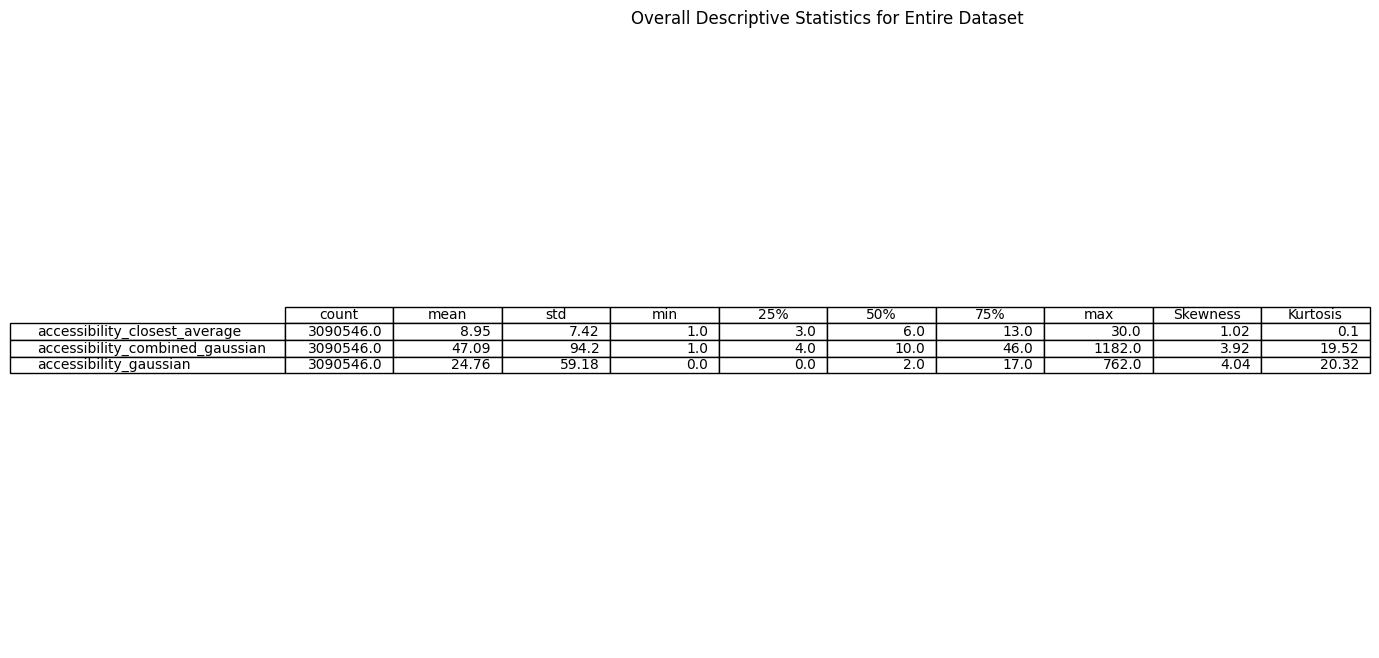

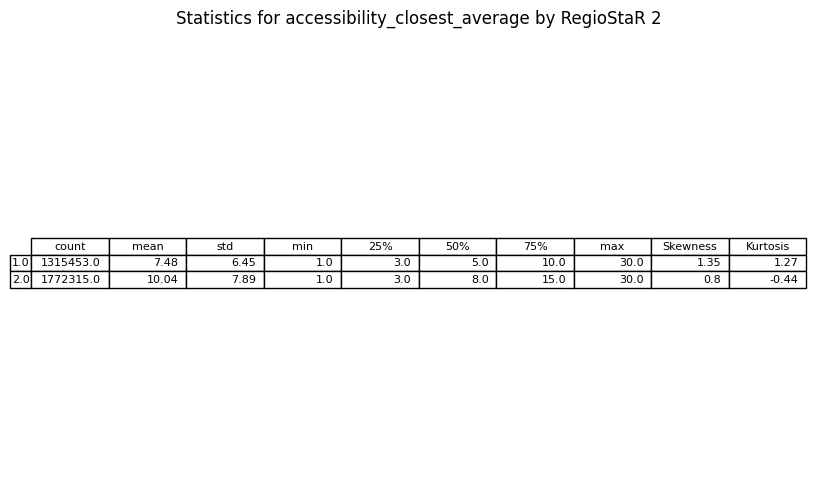

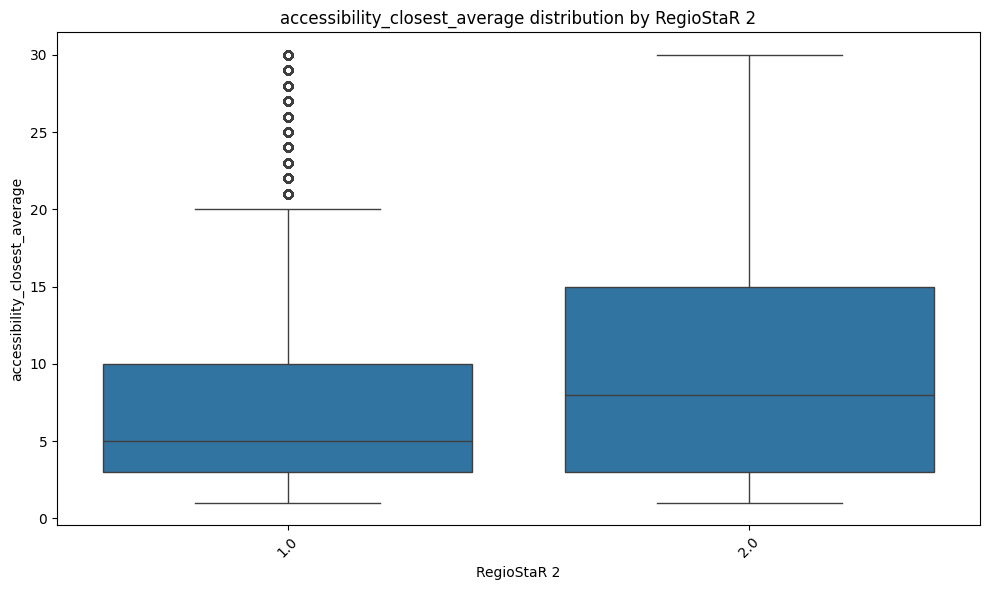

Preparing to plot violin plot for accessibility_closest_average by RegioStaR 2. Valid data lengths: [1315453, 1772315]


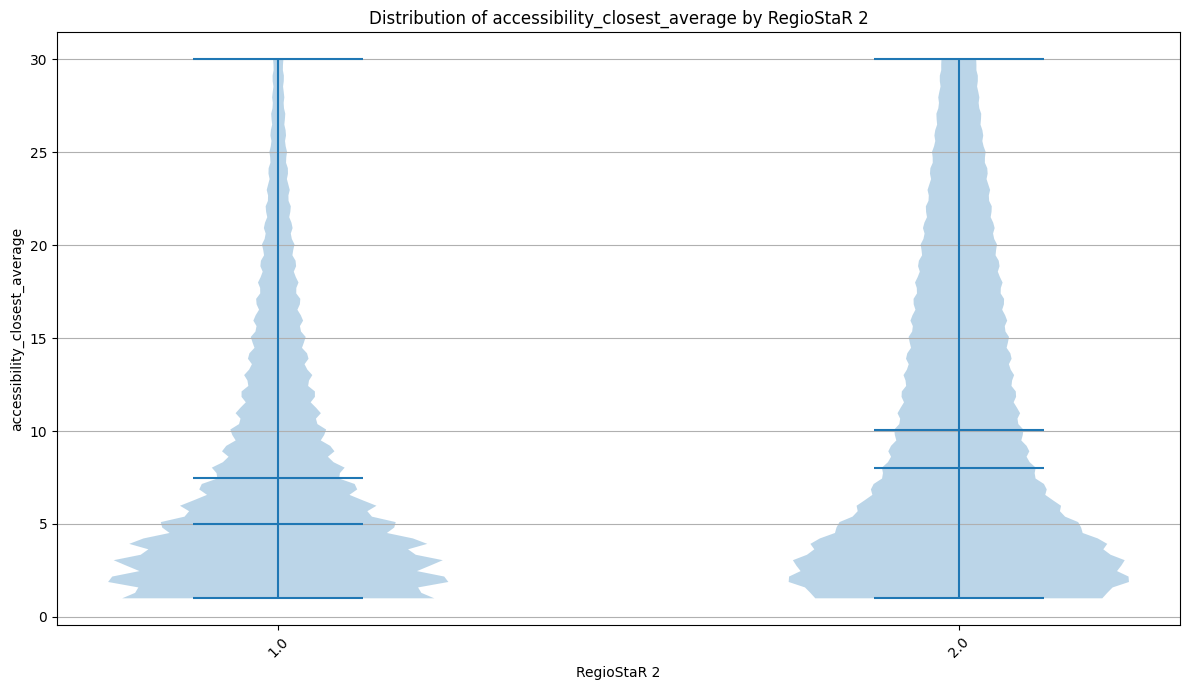

Violin plot generated for accessibility_closest_average by RegioStaR 2


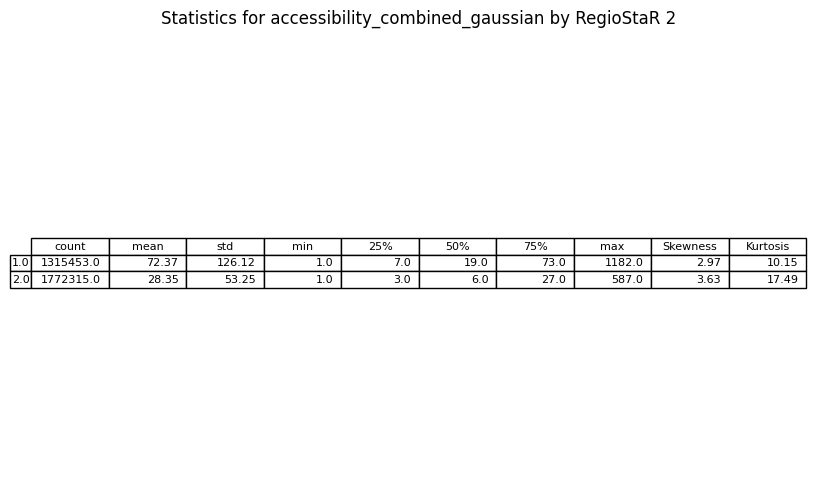

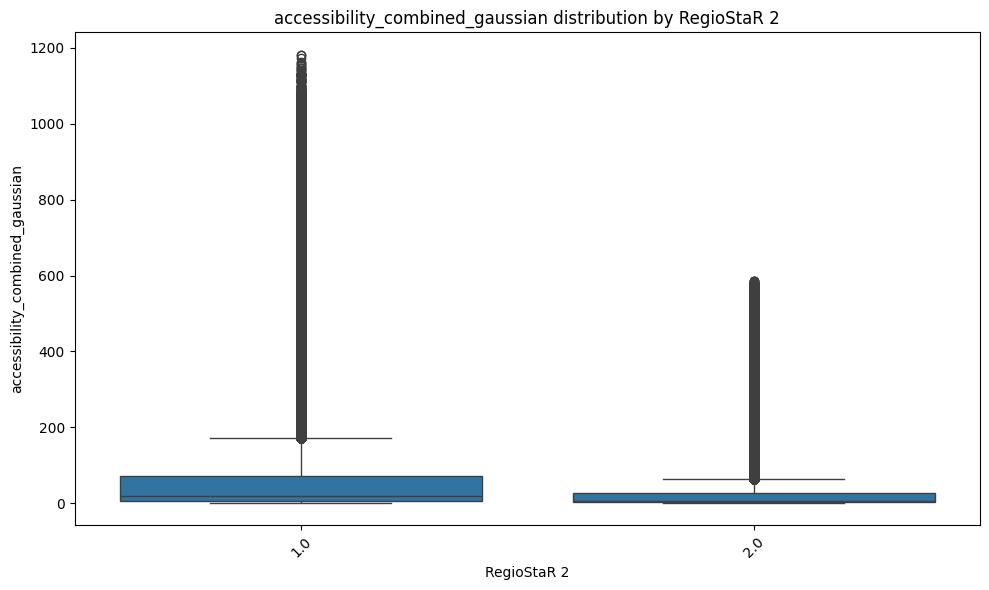

Preparing to plot violin plot for accessibility_combined_gaussian by RegioStaR 2. Valid data lengths: [1315453, 1772315]


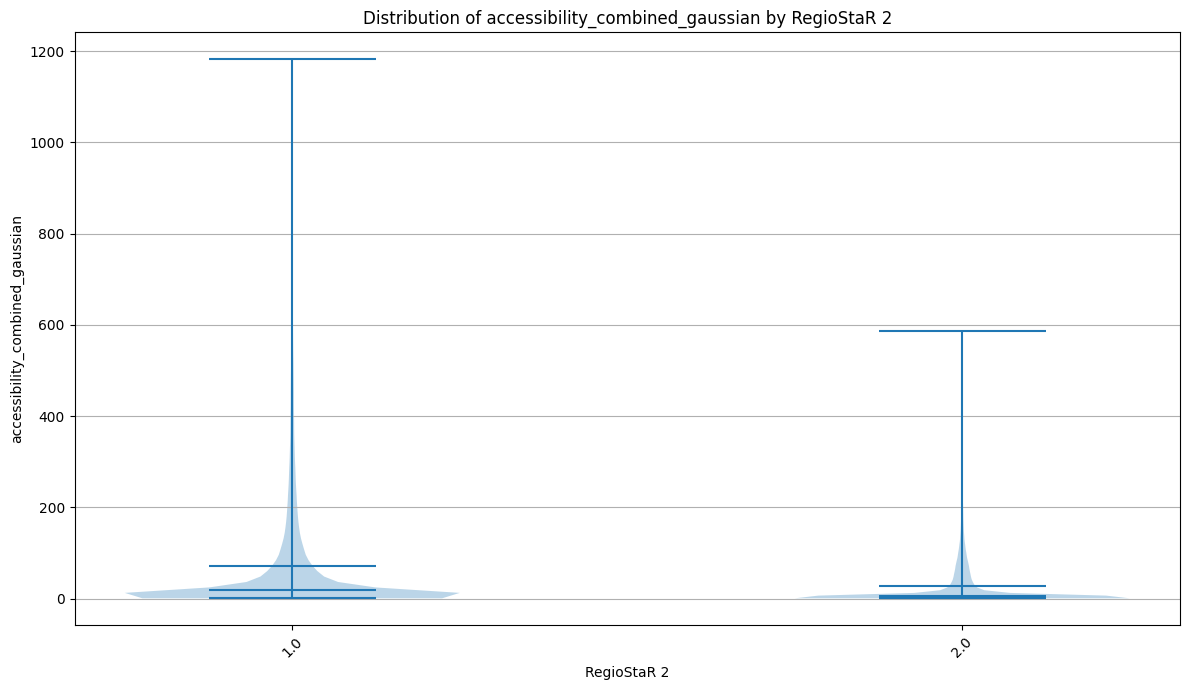

Violin plot generated for accessibility_combined_gaussian by RegioStaR 2


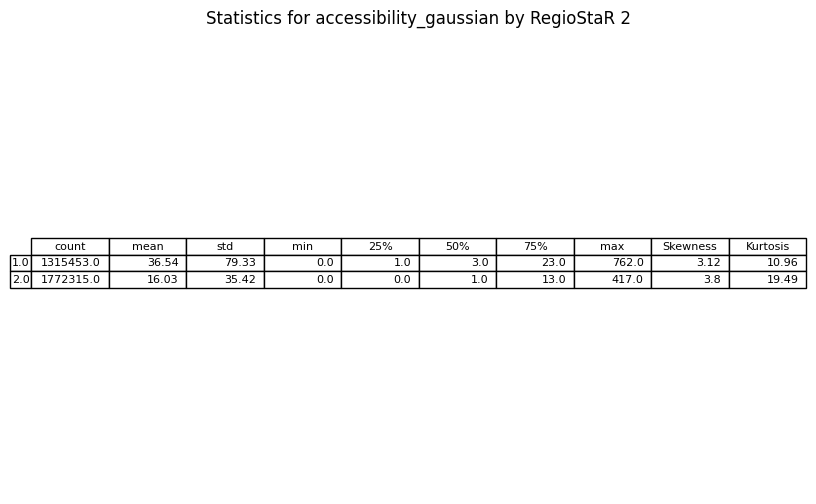

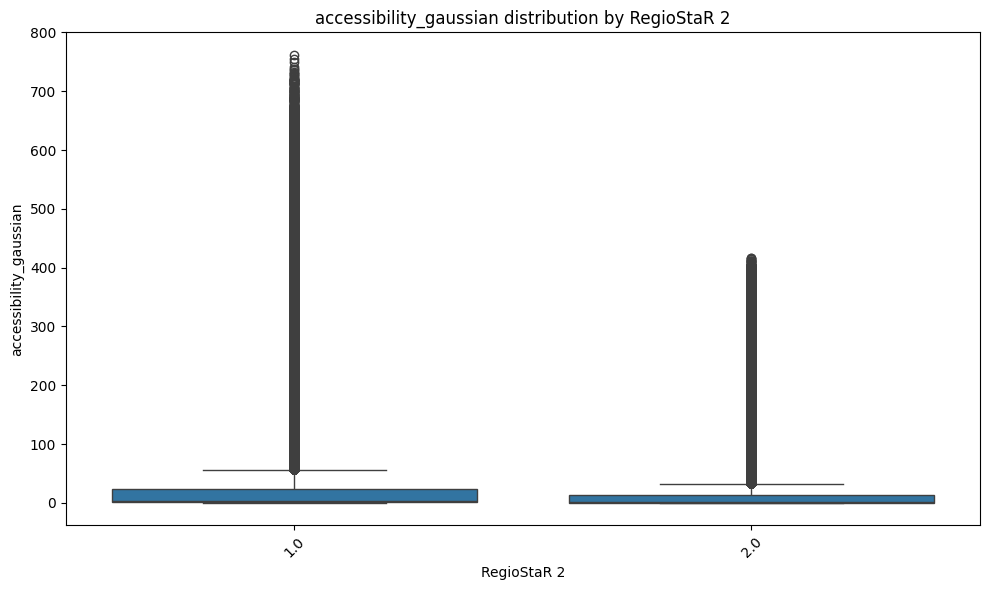

Preparing to plot violin plot for accessibility_gaussian by RegioStaR 2. Valid data lengths: [1315453, 1772315]


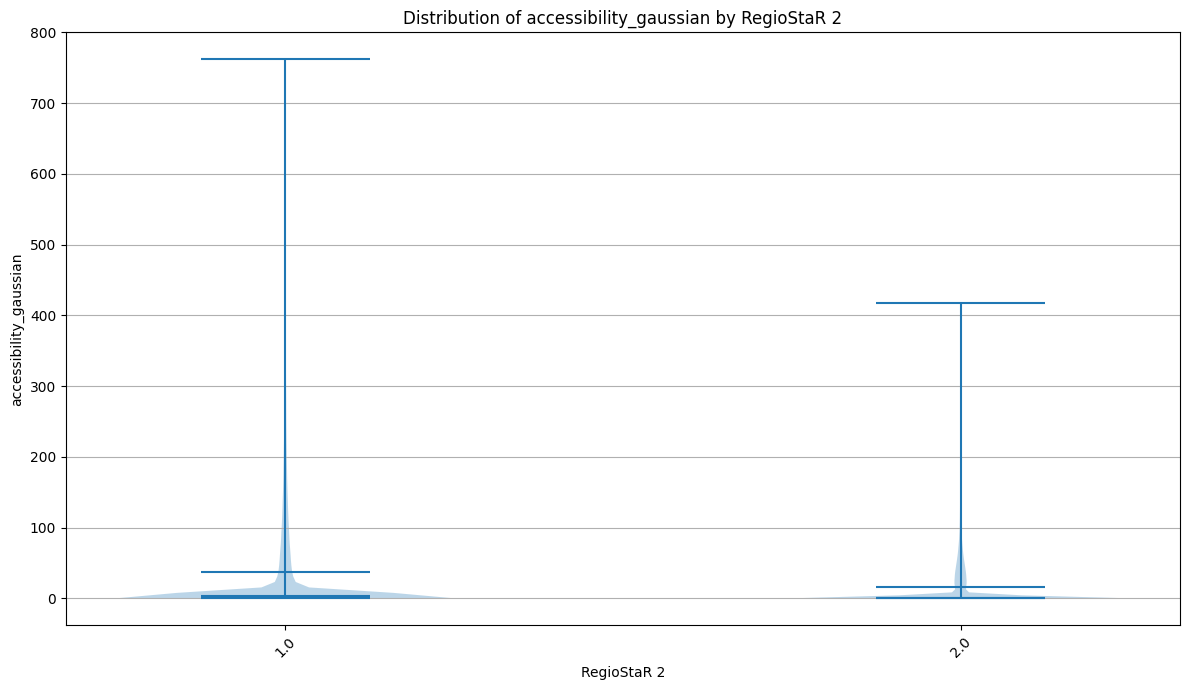

Violin plot generated for accessibility_gaussian by RegioStaR 2


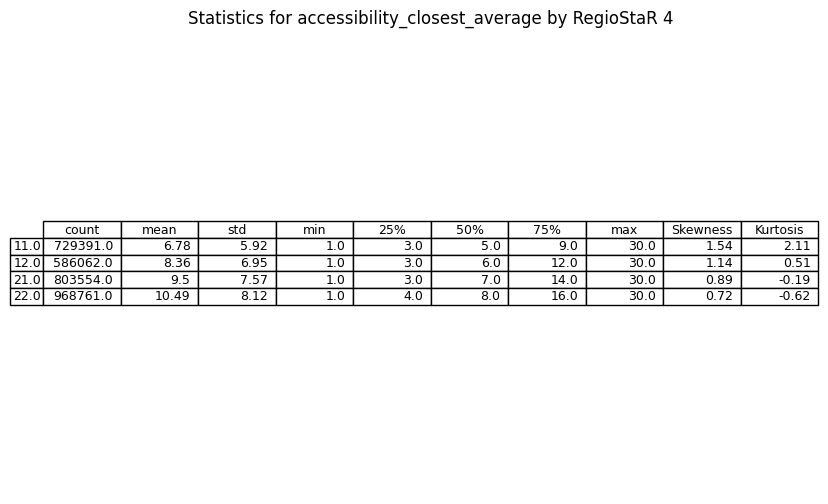

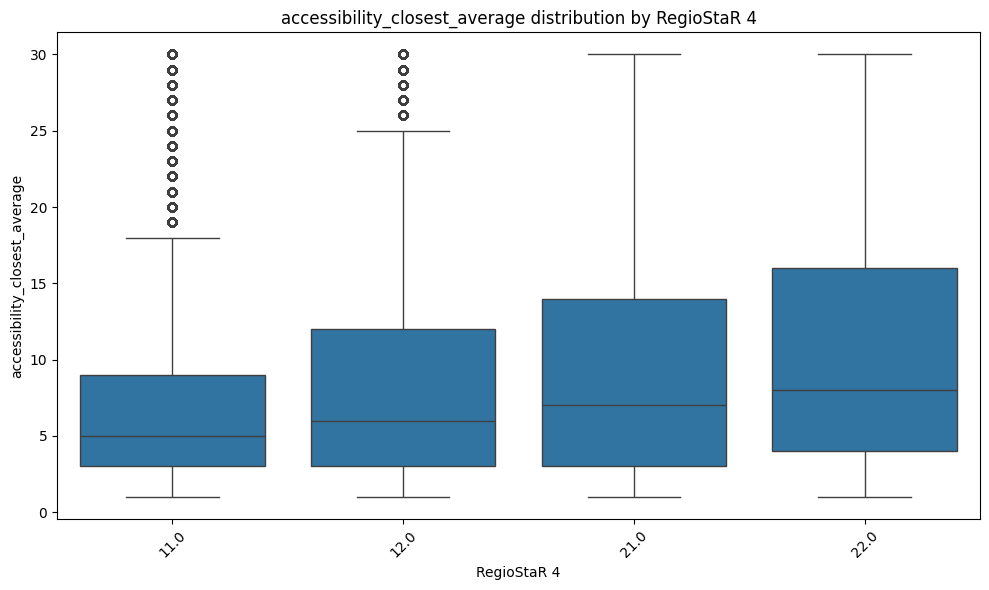

Preparing to plot violin plot for accessibility_closest_average by RegioStaR 4. Valid data lengths: [729391, 586062, 803554, 968761]


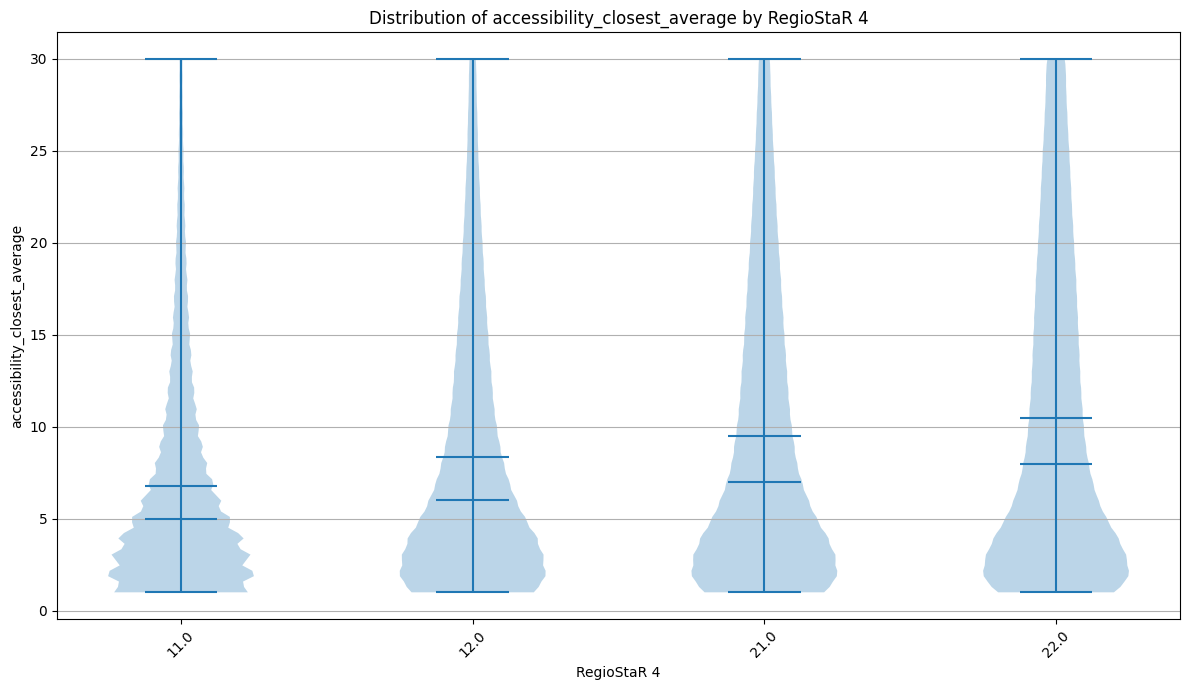

Violin plot generated for accessibility_closest_average by RegioStaR 4


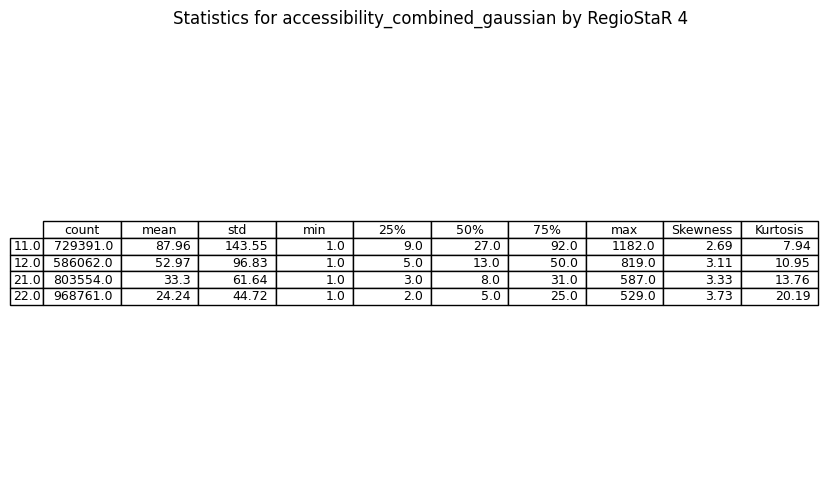

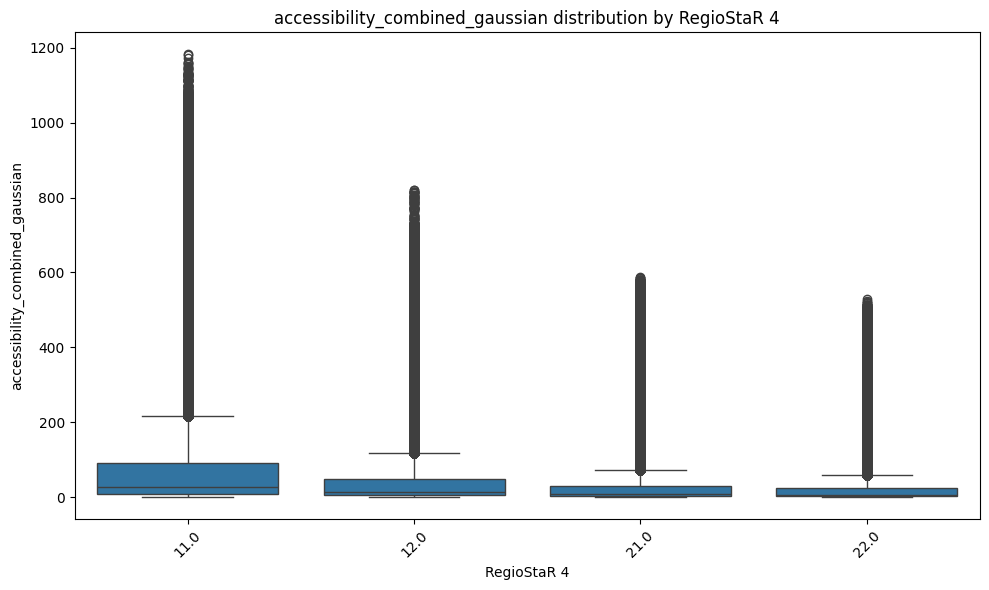

Preparing to plot violin plot for accessibility_combined_gaussian by RegioStaR 4. Valid data lengths: [729391, 586062, 803554, 968761]


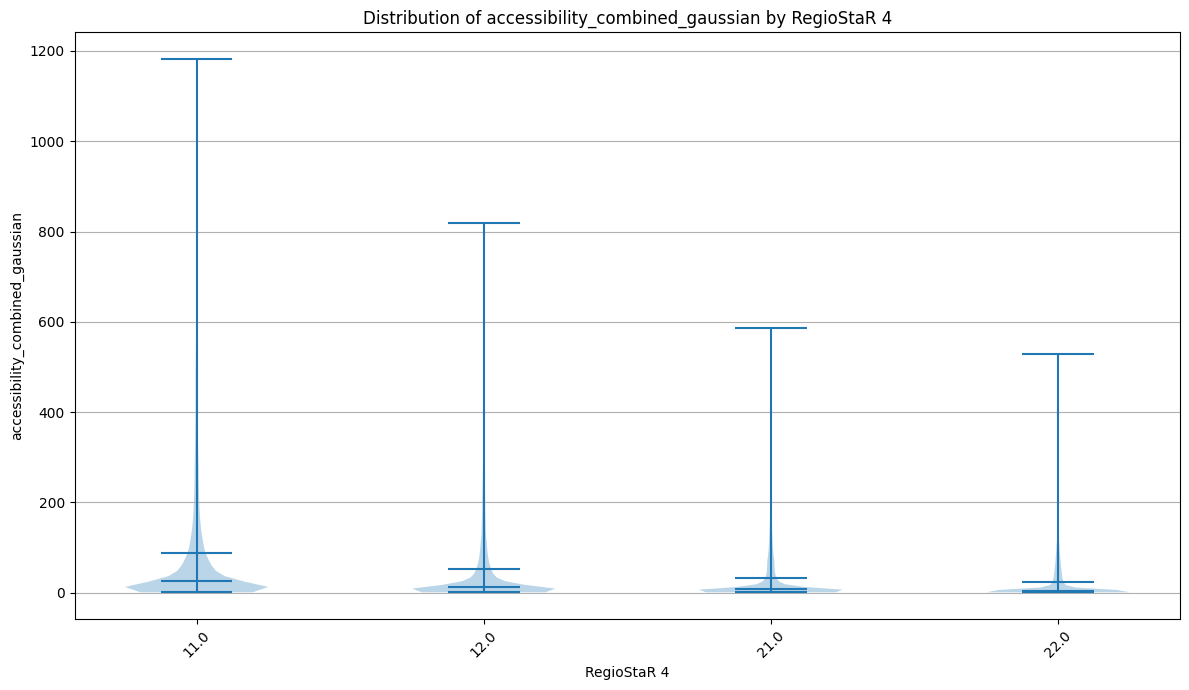

Violin plot generated for accessibility_combined_gaussian by RegioStaR 4


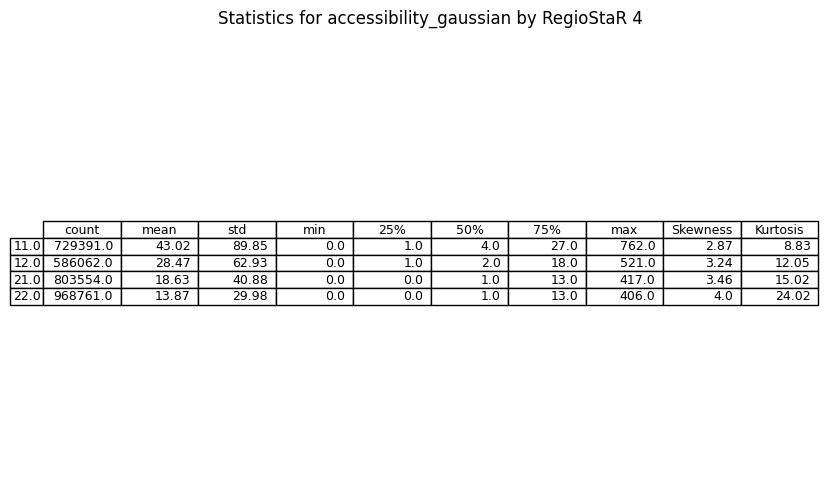

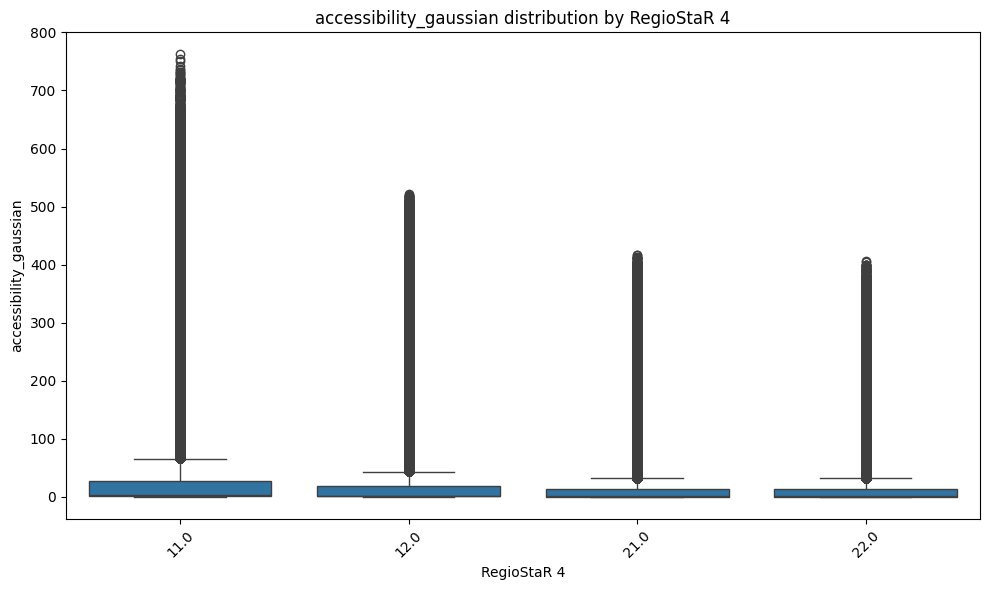

Preparing to plot violin plot for accessibility_gaussian by RegioStaR 4. Valid data lengths: [729391, 586062, 803554, 968761]


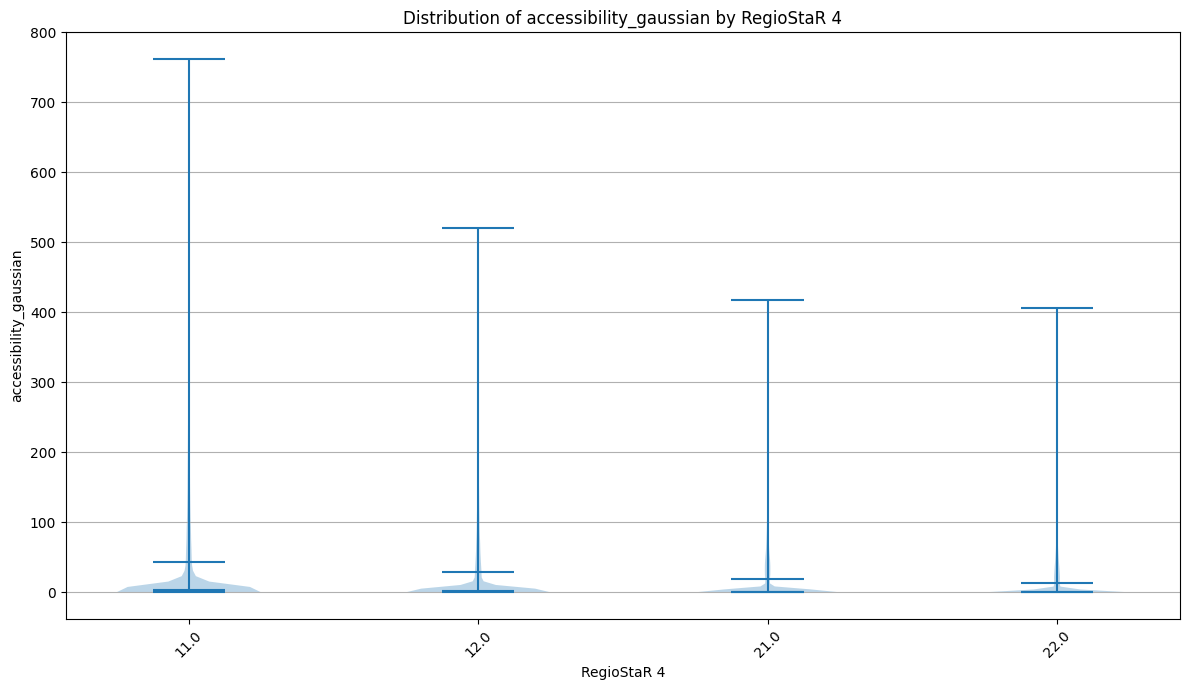

Violin plot generated for accessibility_gaussian by RegioStaR 4


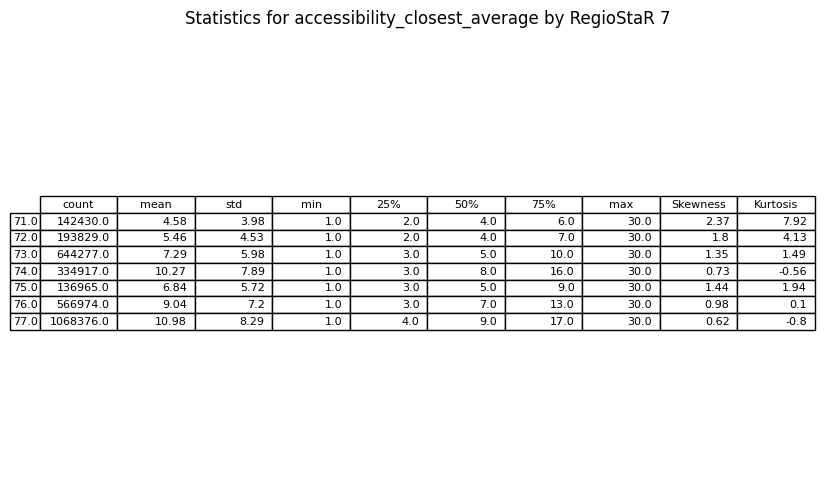

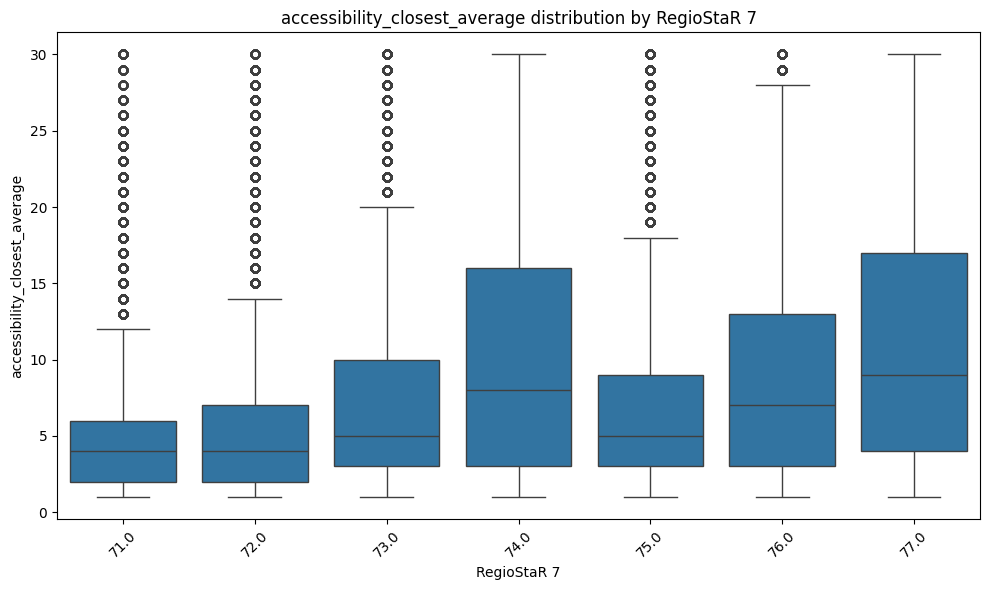

Preparing to plot violin plot for accessibility_closest_average by RegioStaR 7. Valid data lengths: [142430, 193829, 644277, 334917, 136965, 566974, 1068376]


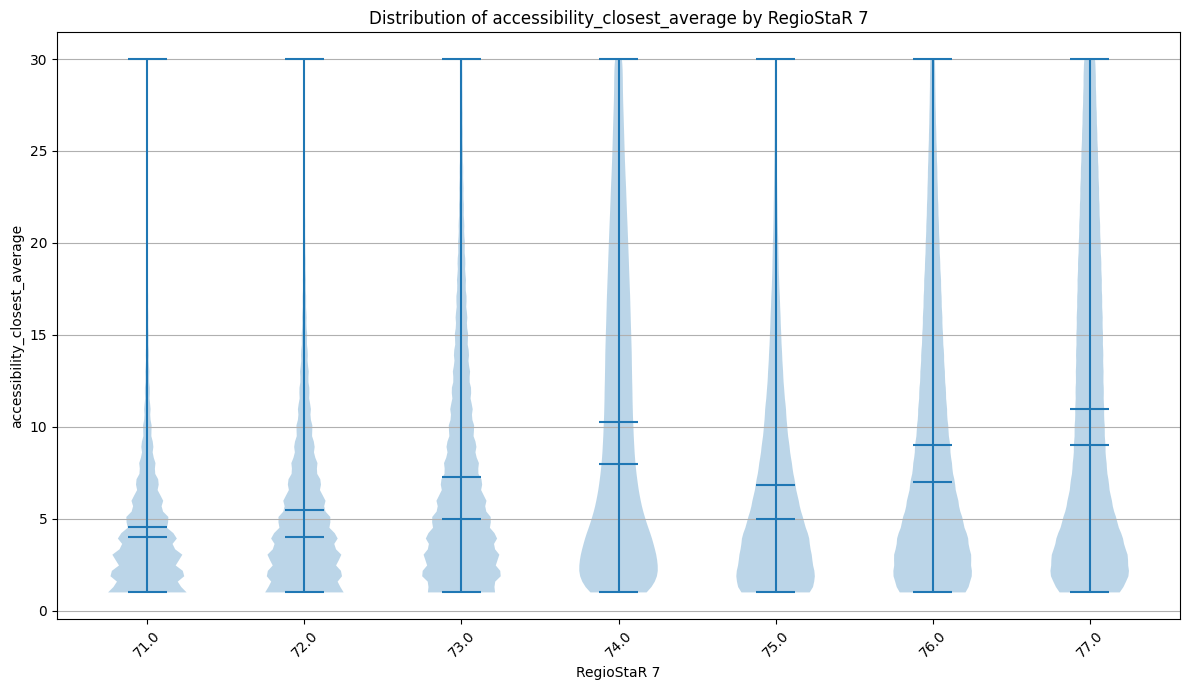

Violin plot generated for accessibility_closest_average by RegioStaR 7


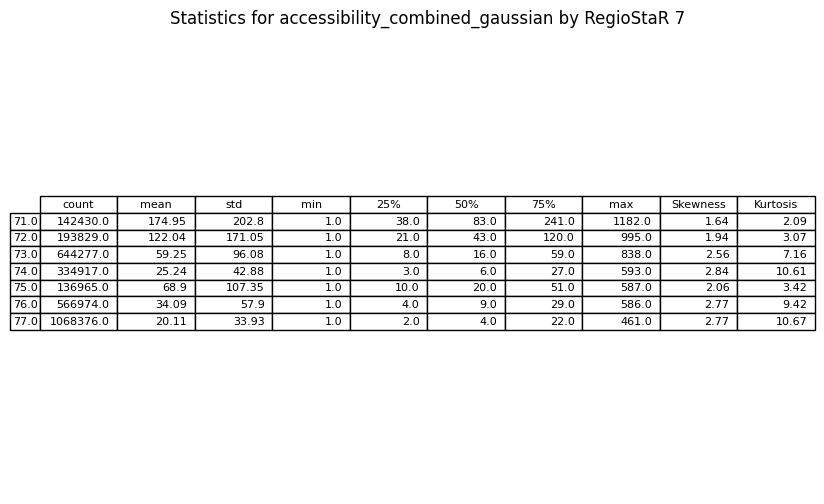

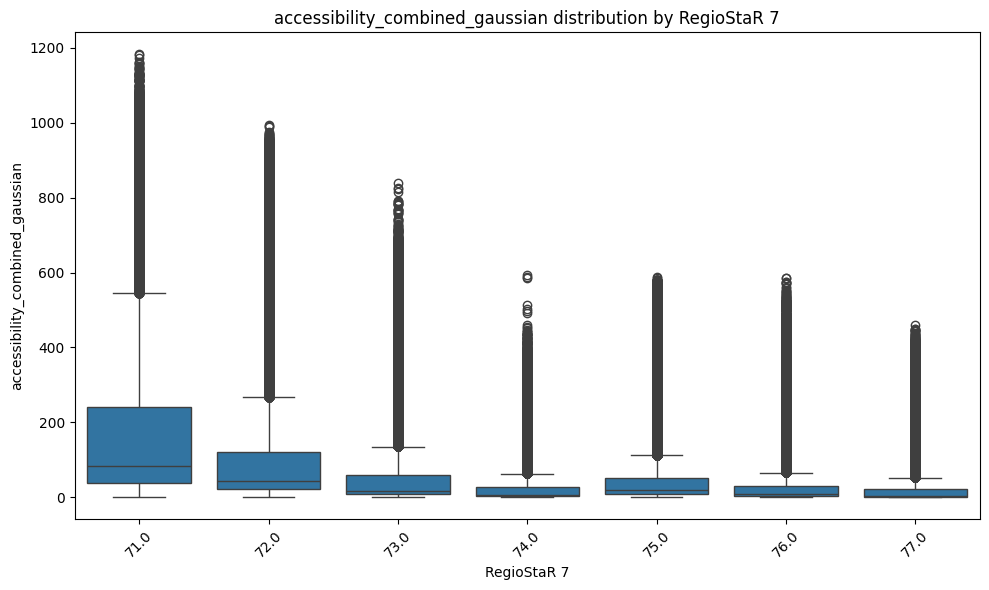

Preparing to plot violin plot for accessibility_combined_gaussian by RegioStaR 7. Valid data lengths: [142430, 193829, 644277, 334917, 136965, 566974, 1068376]


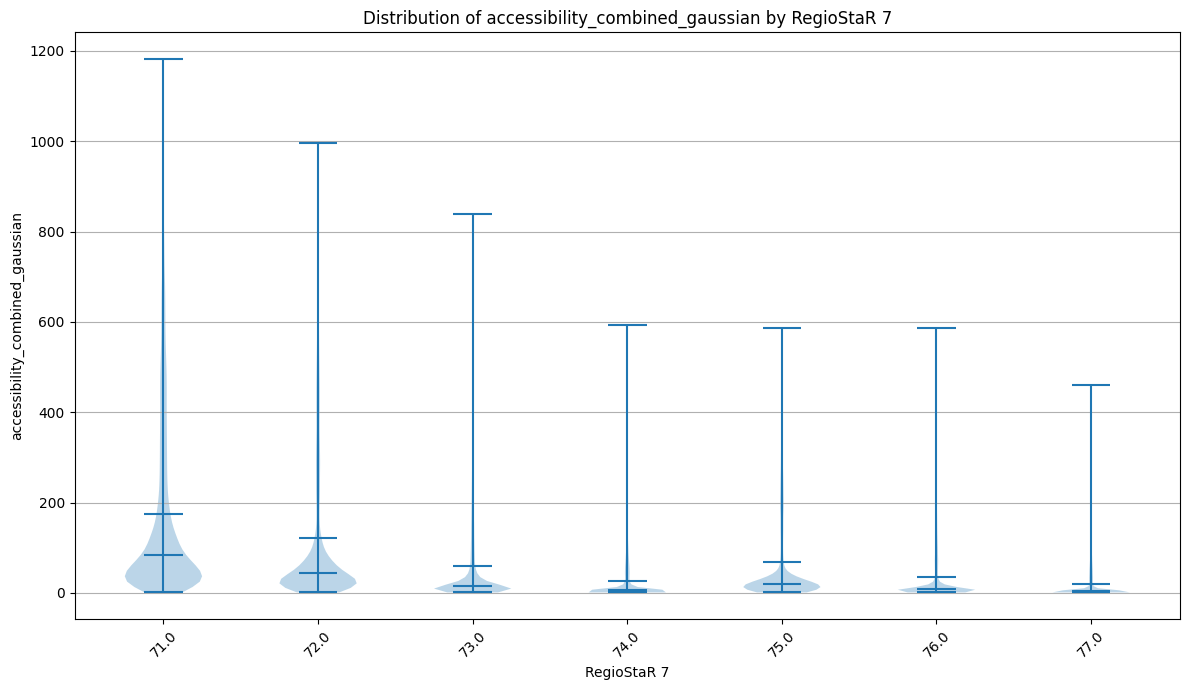

Violin plot generated for accessibility_combined_gaussian by RegioStaR 7


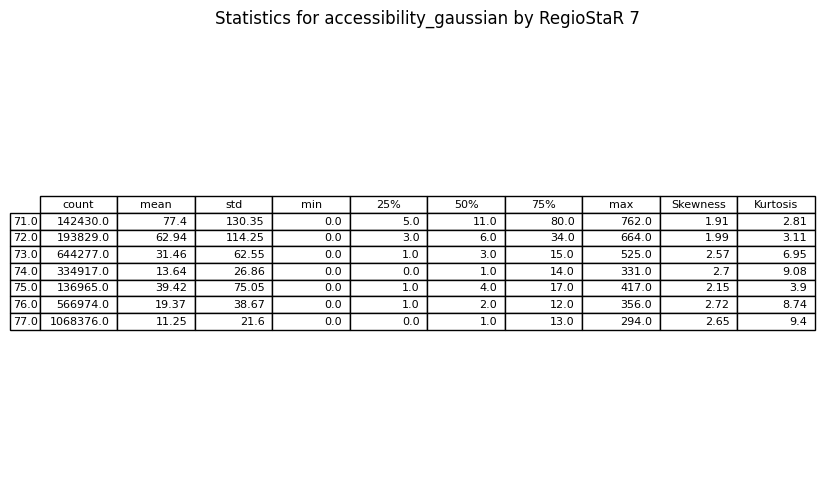

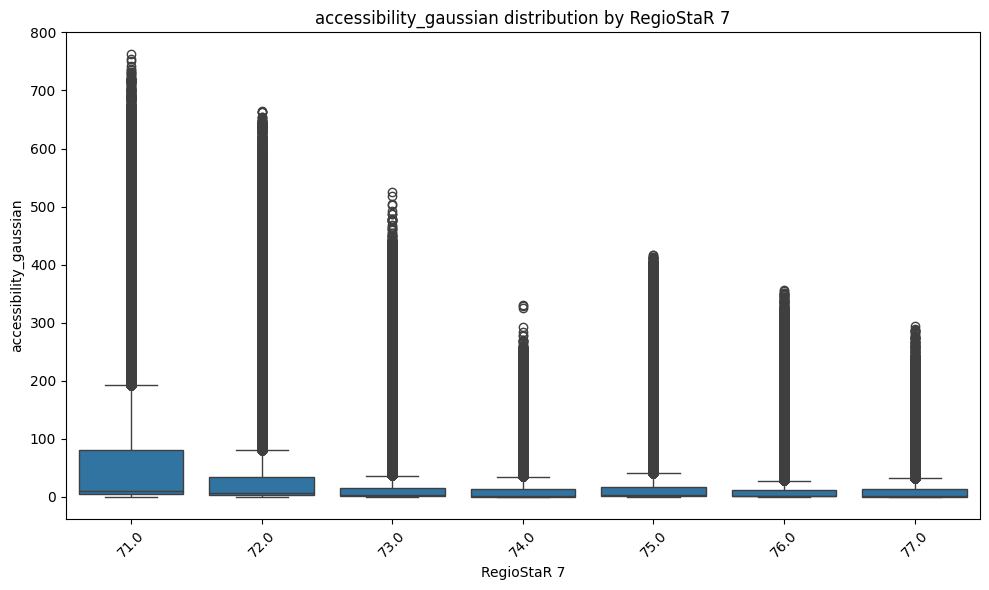

Preparing to plot violin plot for accessibility_gaussian by RegioStaR 7. Valid data lengths: [142430, 193829, 644277, 334917, 136965, 566974, 1068376]


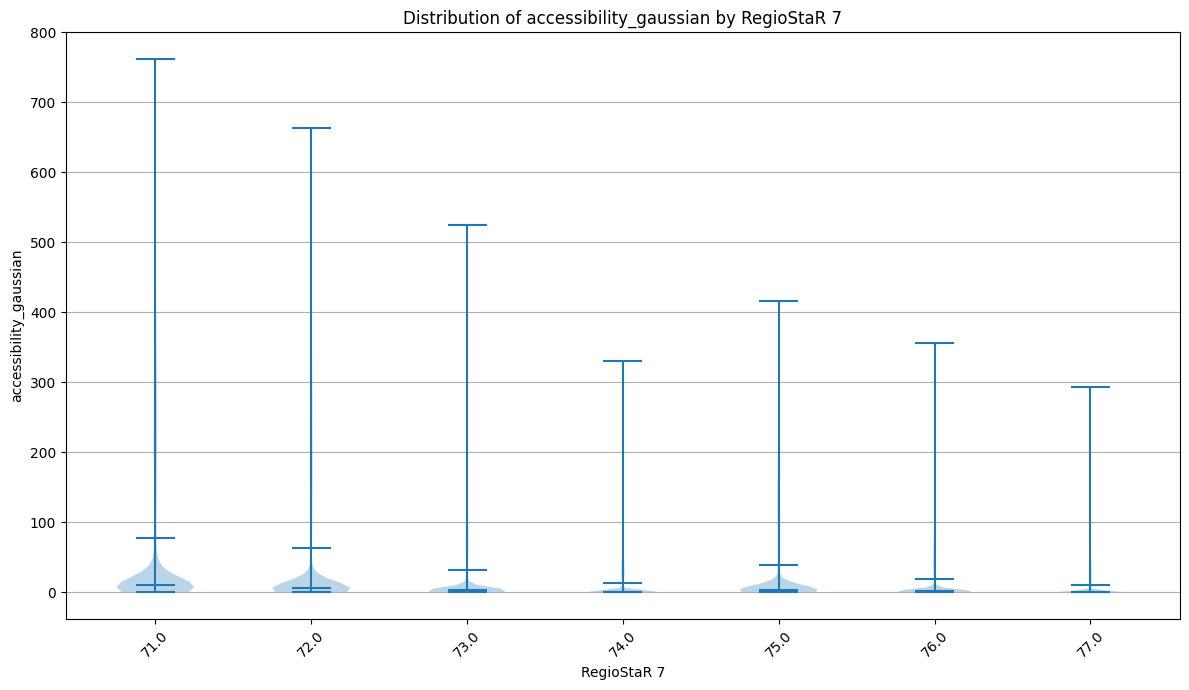

Violin plot generated for accessibility_gaussian by RegioStaR 7


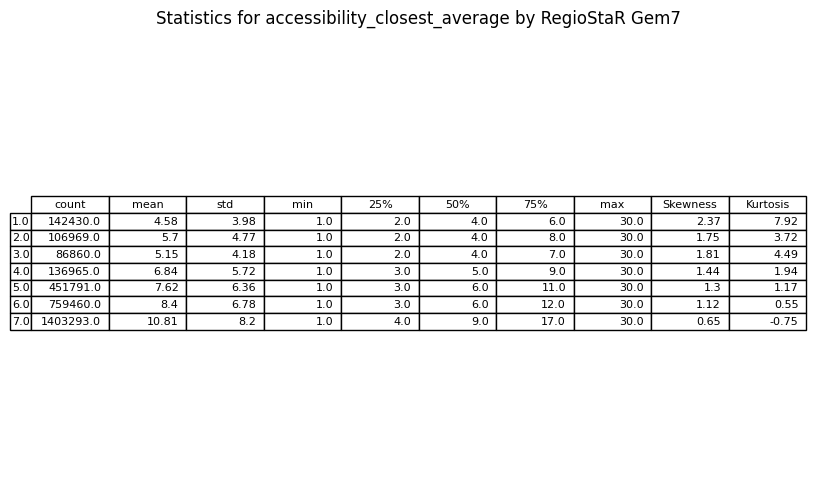

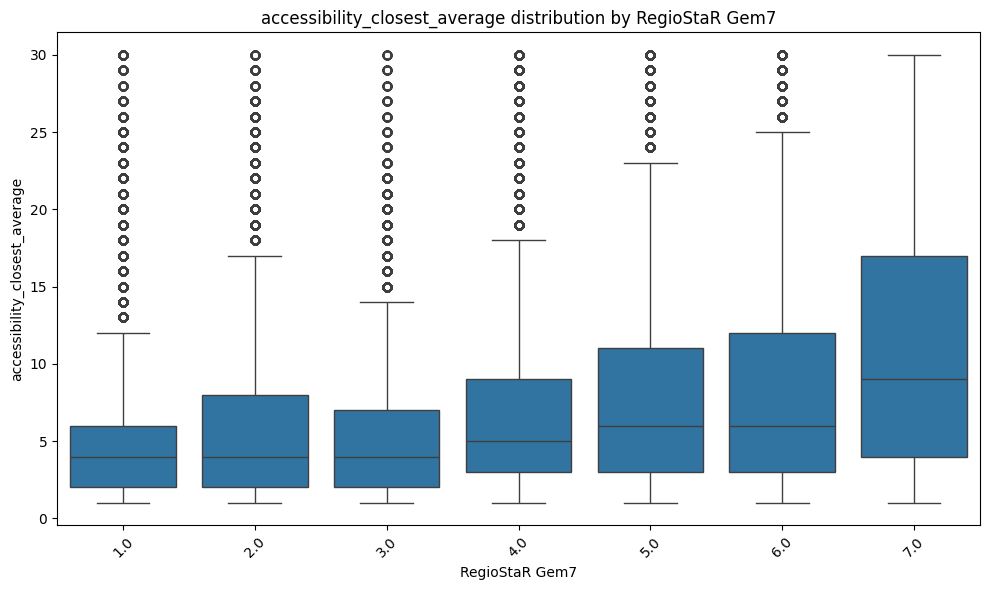

Preparing to plot violin plot for accessibility_closest_average by RegioStaR Gem7. Valid data lengths: [142430, 106969, 86860, 136965, 451791, 759460, 1403293]


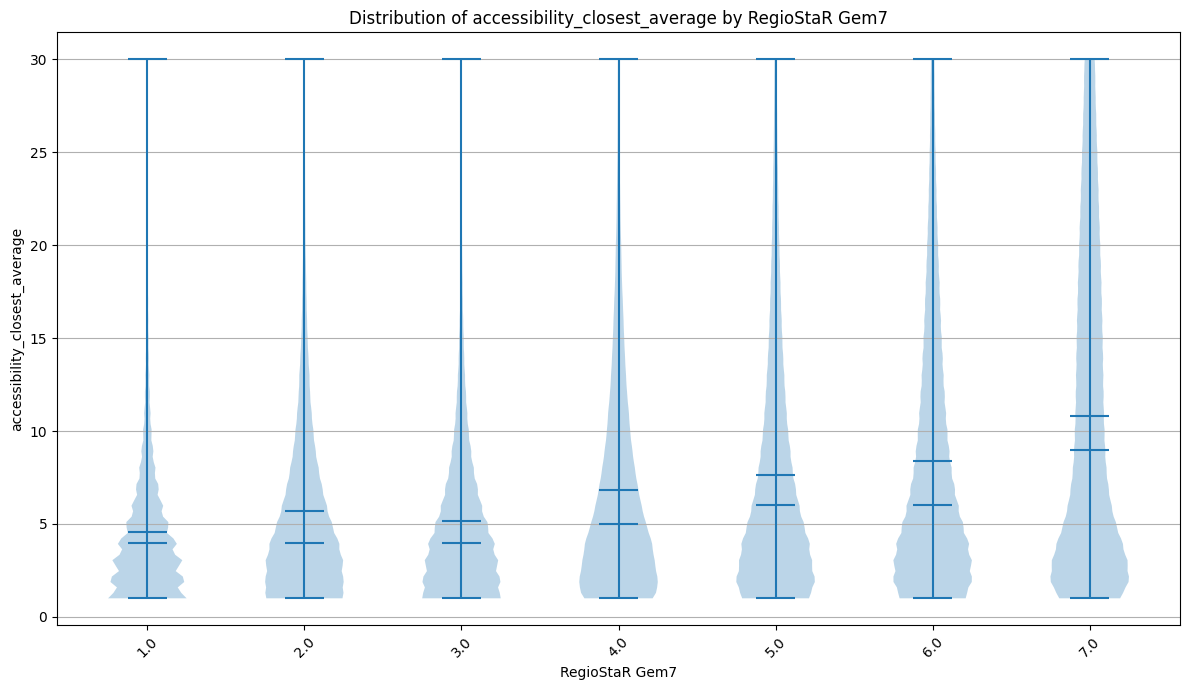

Violin plot generated for accessibility_closest_average by RegioStaR Gem7


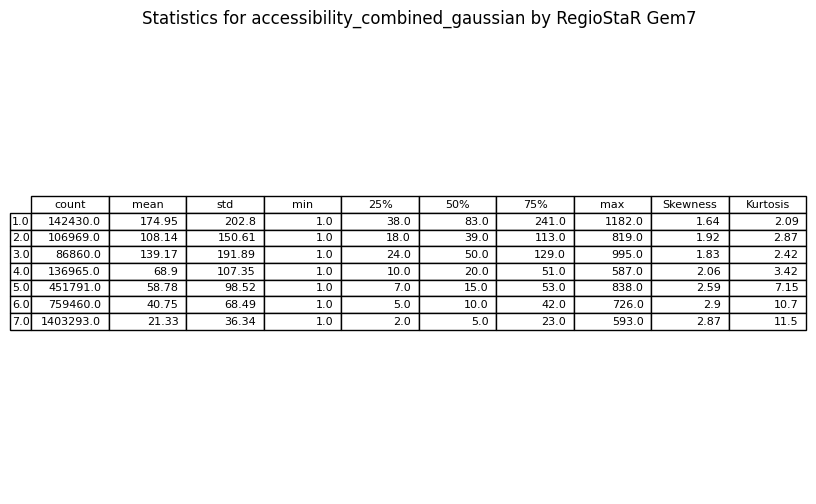

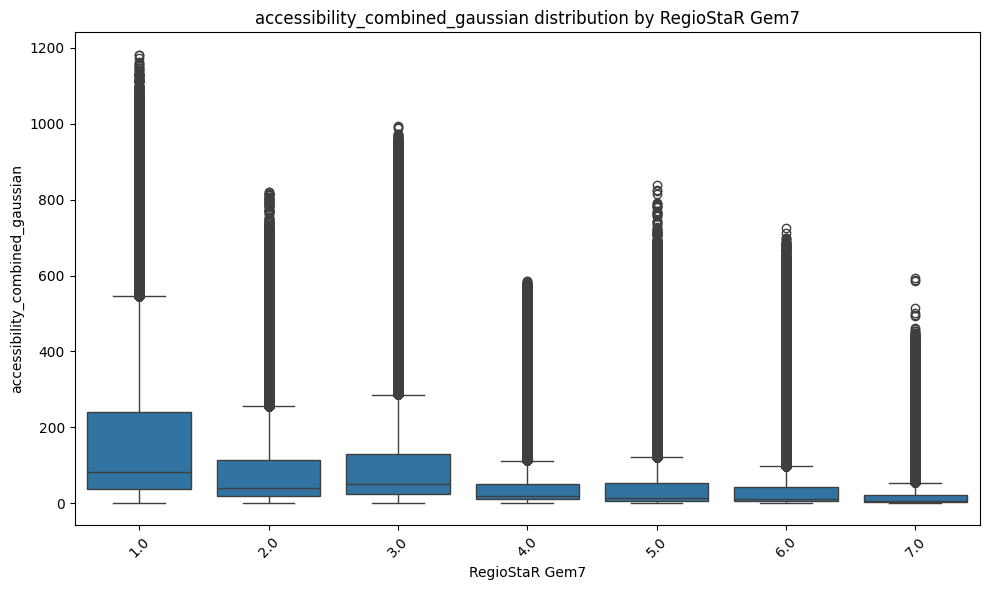

Preparing to plot violin plot for accessibility_combined_gaussian by RegioStaR Gem7. Valid data lengths: [142430, 106969, 86860, 136965, 451791, 759460, 1403293]


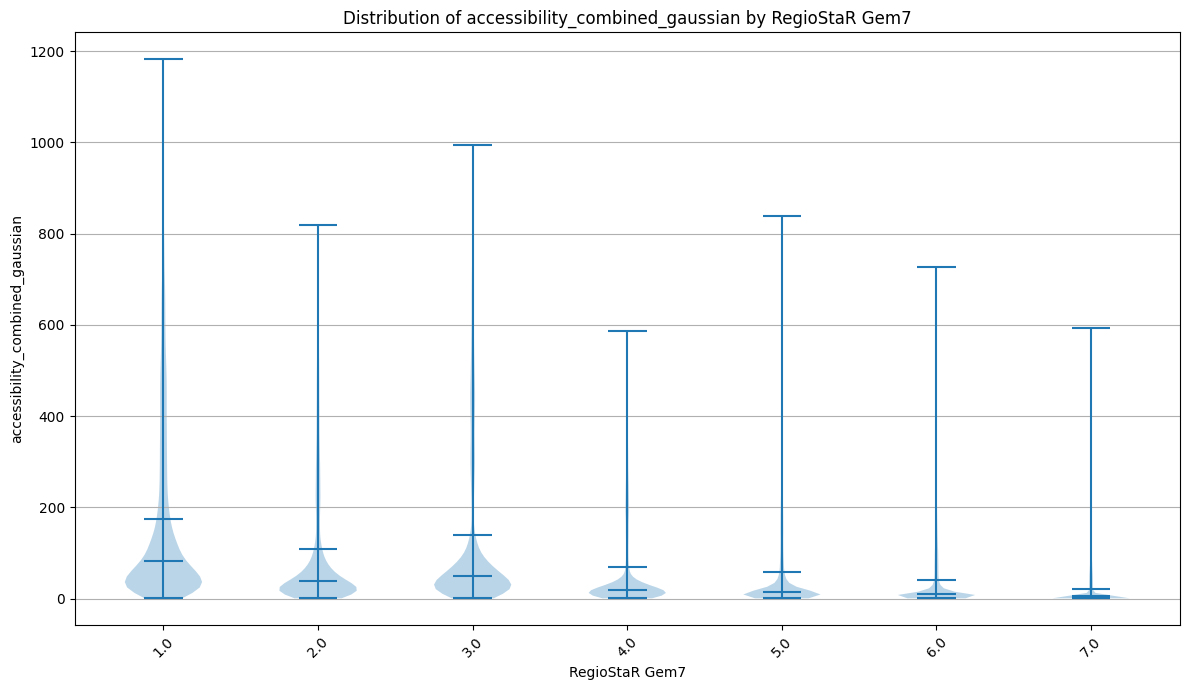

Violin plot generated for accessibility_combined_gaussian by RegioStaR Gem7


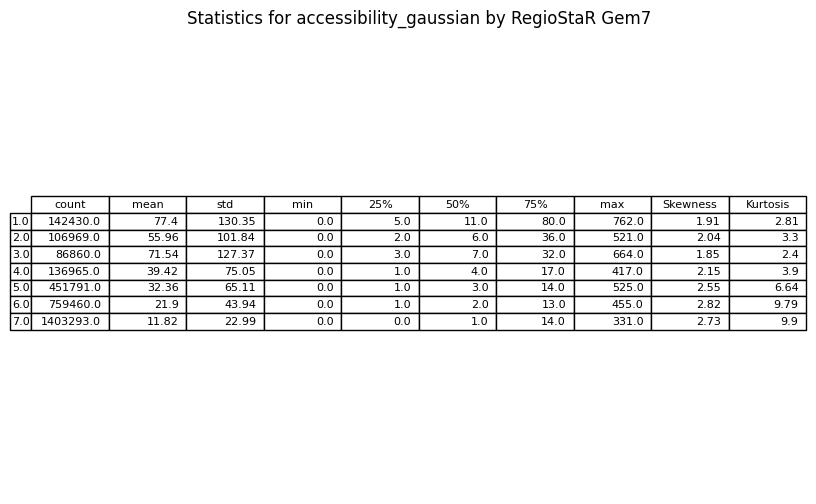

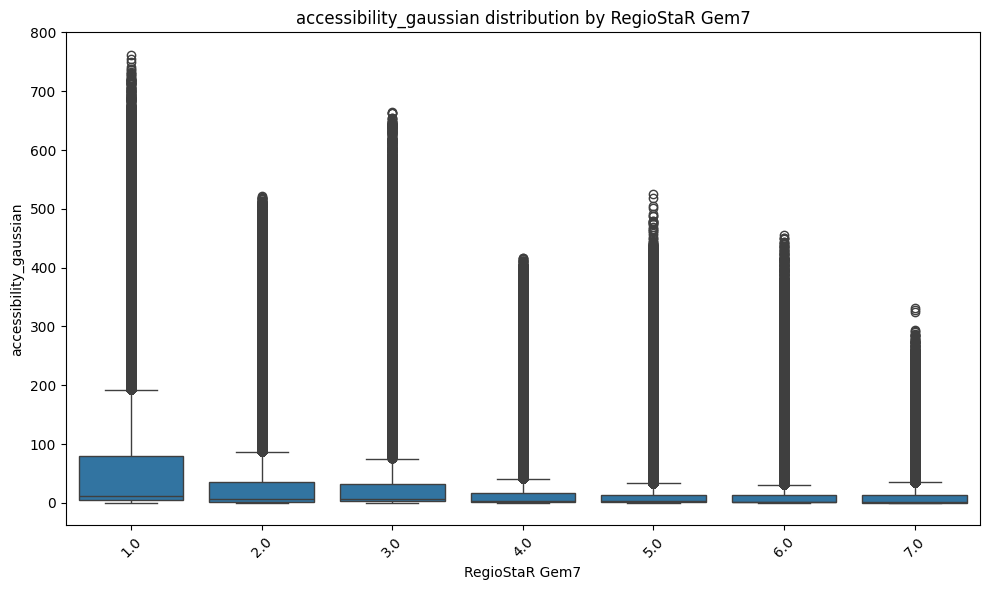

Preparing to plot violin plot for accessibility_gaussian by RegioStaR Gem7. Valid data lengths: [142430, 106969, 86860, 136965, 451791, 759460, 1403293]


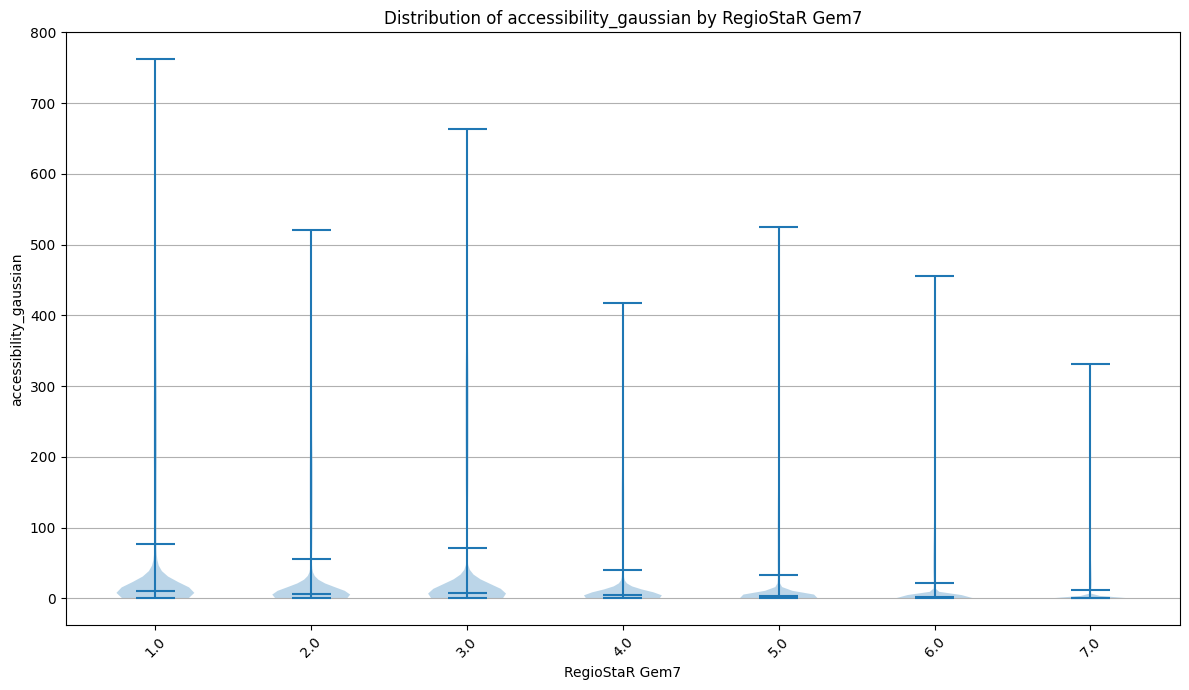

Violin plot generated for accessibility_gaussian by RegioStaR Gem7


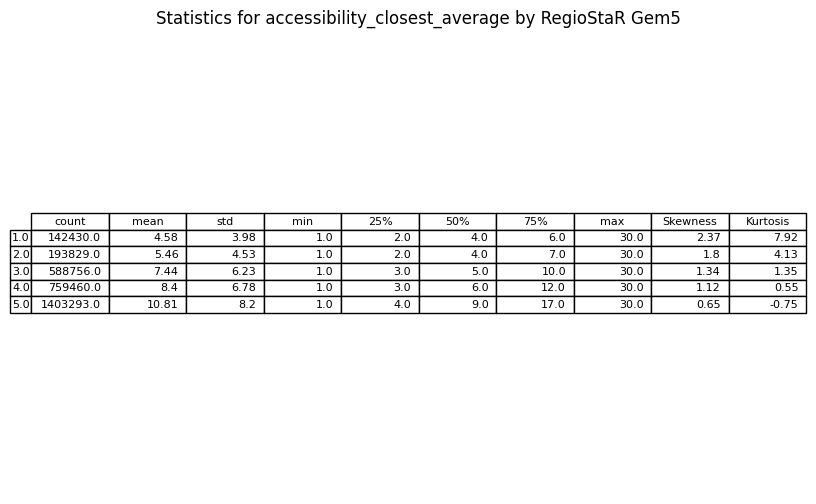

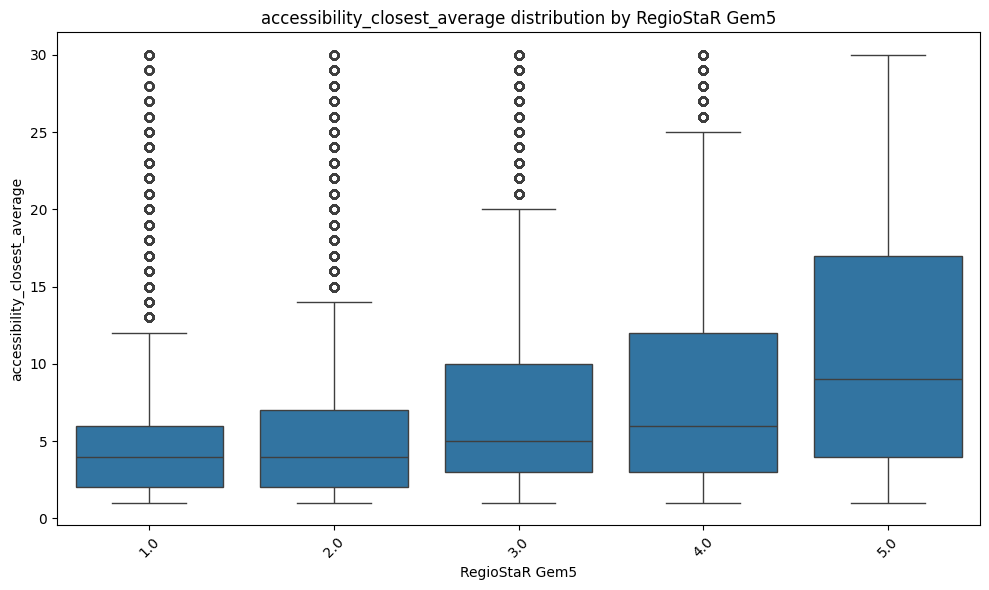

Preparing to plot violin plot for accessibility_closest_average by RegioStaR Gem5. Valid data lengths: [142430, 193829, 588756, 759460, 1403293]


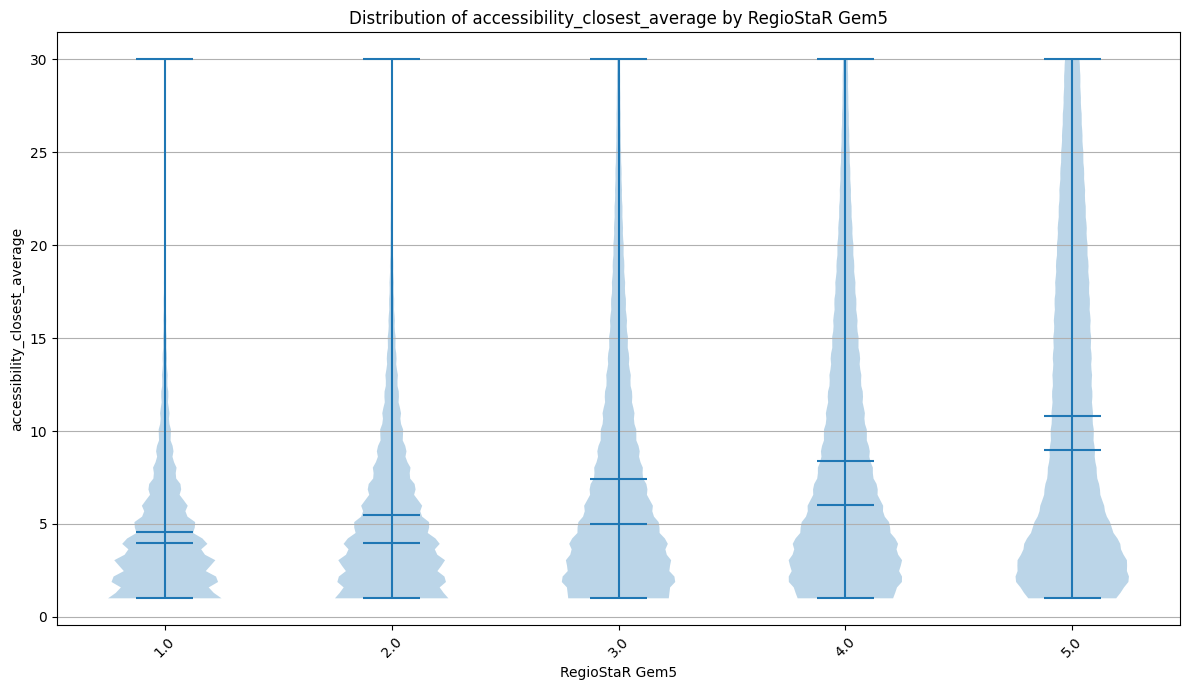

Violin plot generated for accessibility_closest_average by RegioStaR Gem5


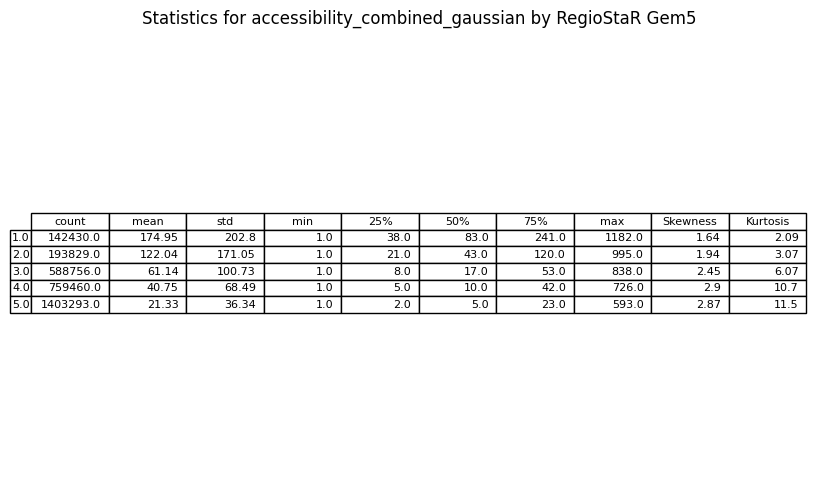

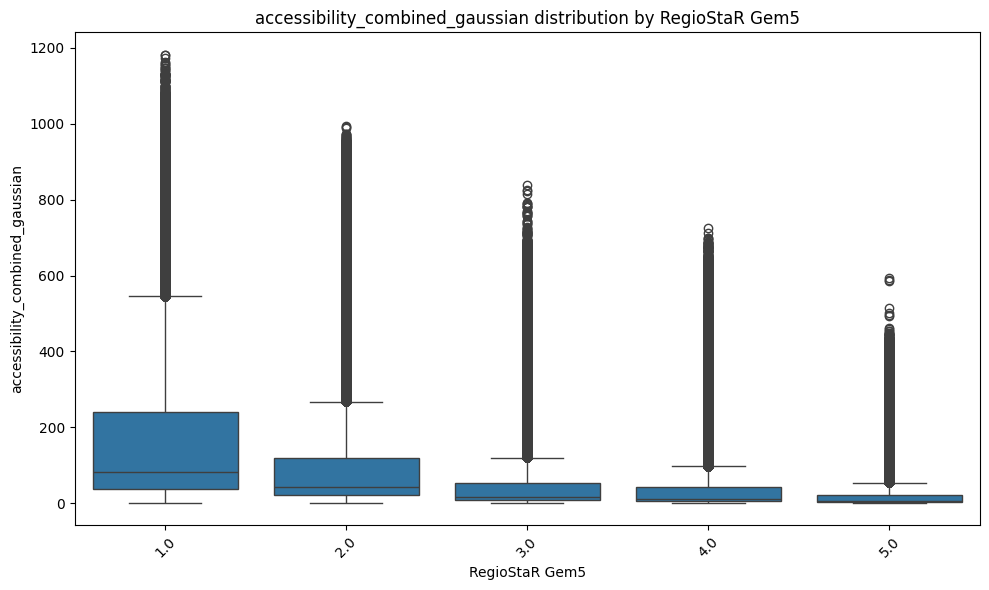

Preparing to plot violin plot for accessibility_combined_gaussian by RegioStaR Gem5. Valid data lengths: [142430, 193829, 588756, 759460, 1403293]


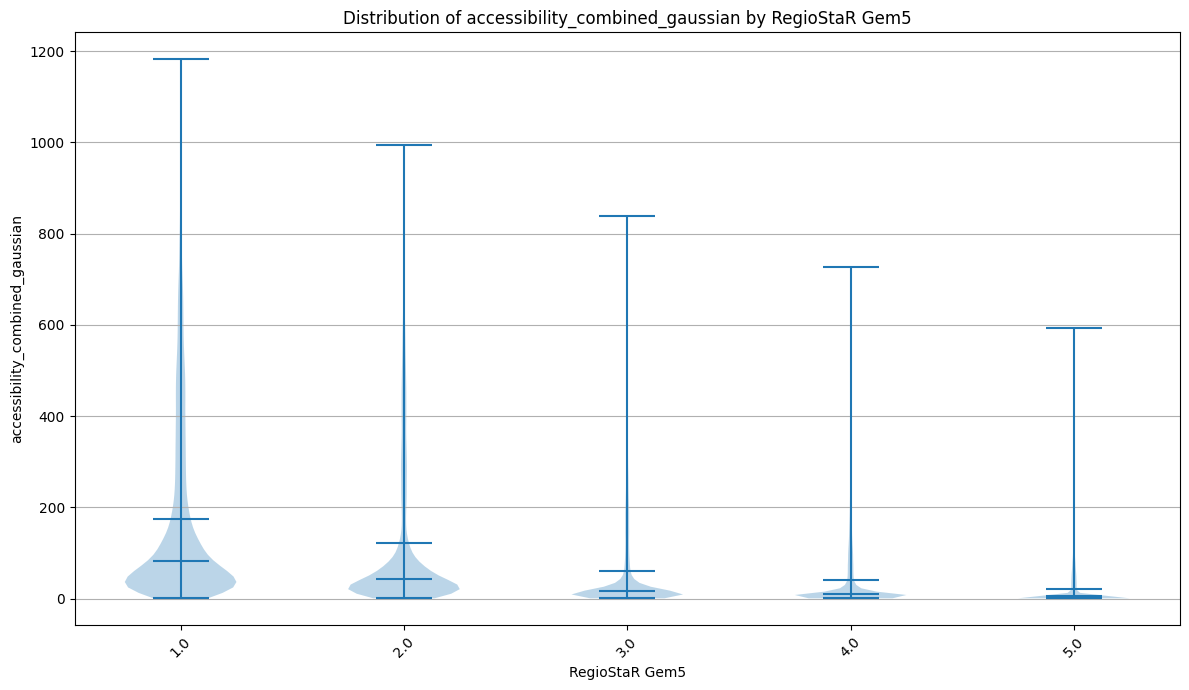

Violin plot generated for accessibility_combined_gaussian by RegioStaR Gem5


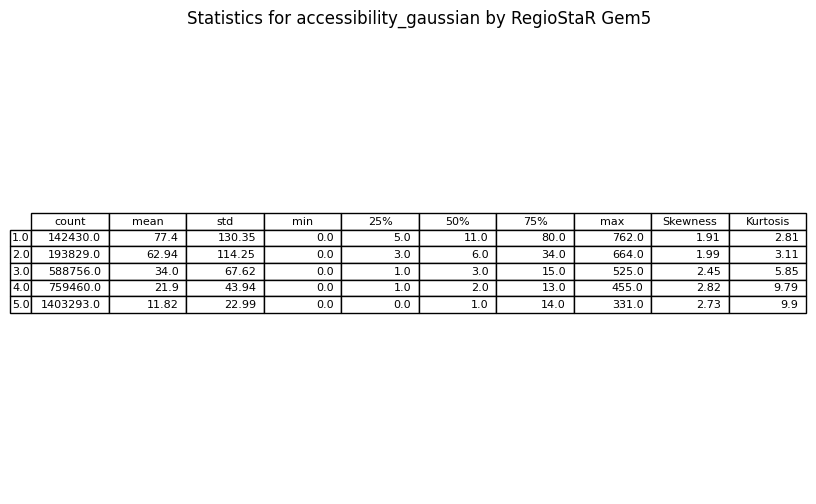

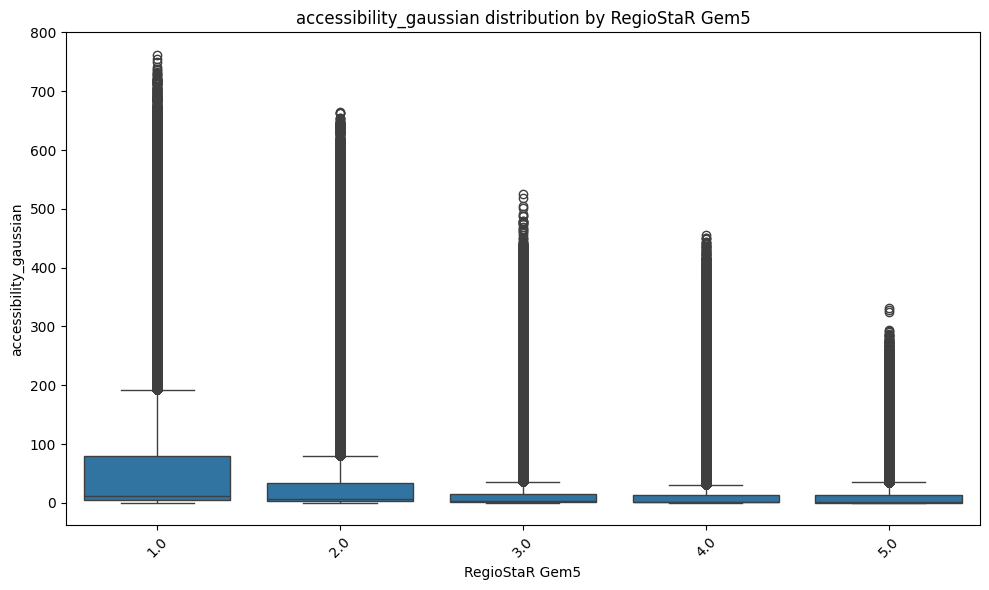

Preparing to plot violin plot for accessibility_gaussian by RegioStaR Gem5. Valid data lengths: [142430, 193829, 588756, 759460, 1403293]


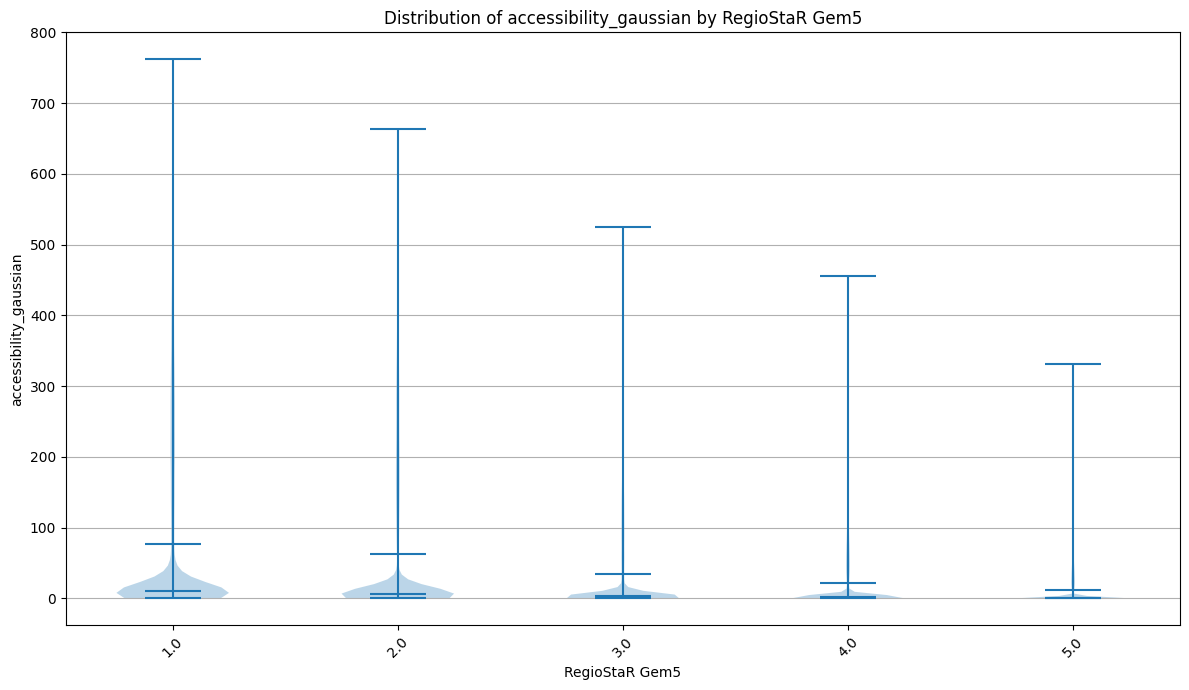

Violin plot generated for accessibility_gaussian by RegioStaR Gem5


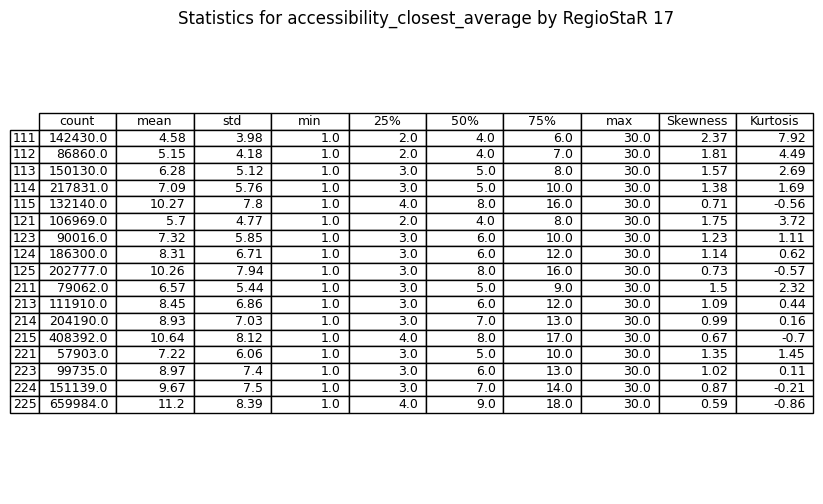

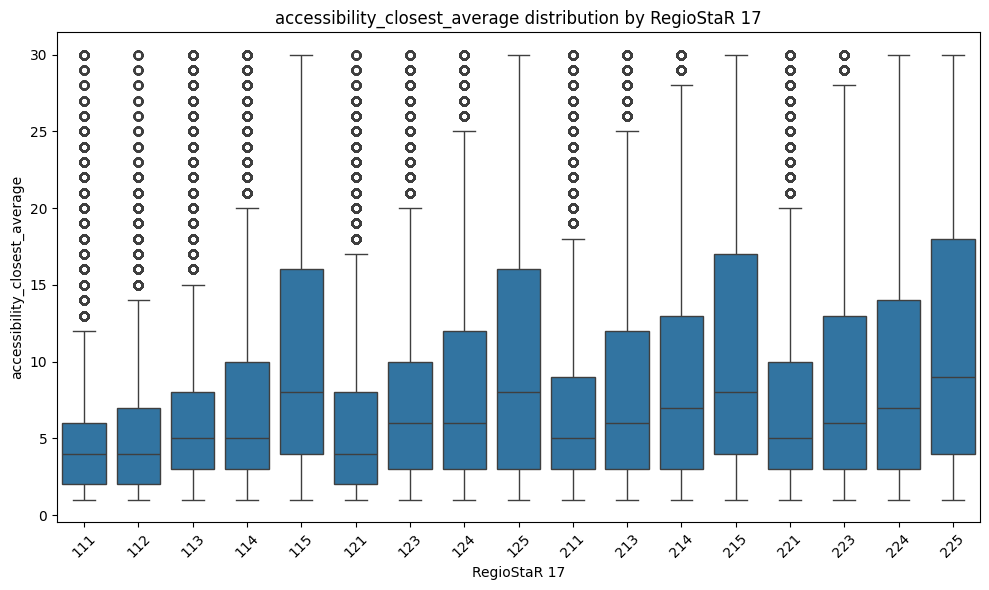

Preparing to plot violin plot for accessibility_closest_average by RegioStaR 17. Valid data lengths: [142430, 86860, 150130, 217831, 132140, 106969, 90016, 186300, 202777, 79062, 111910, 204190, 408392, 57903, 99735, 151139, 659984]


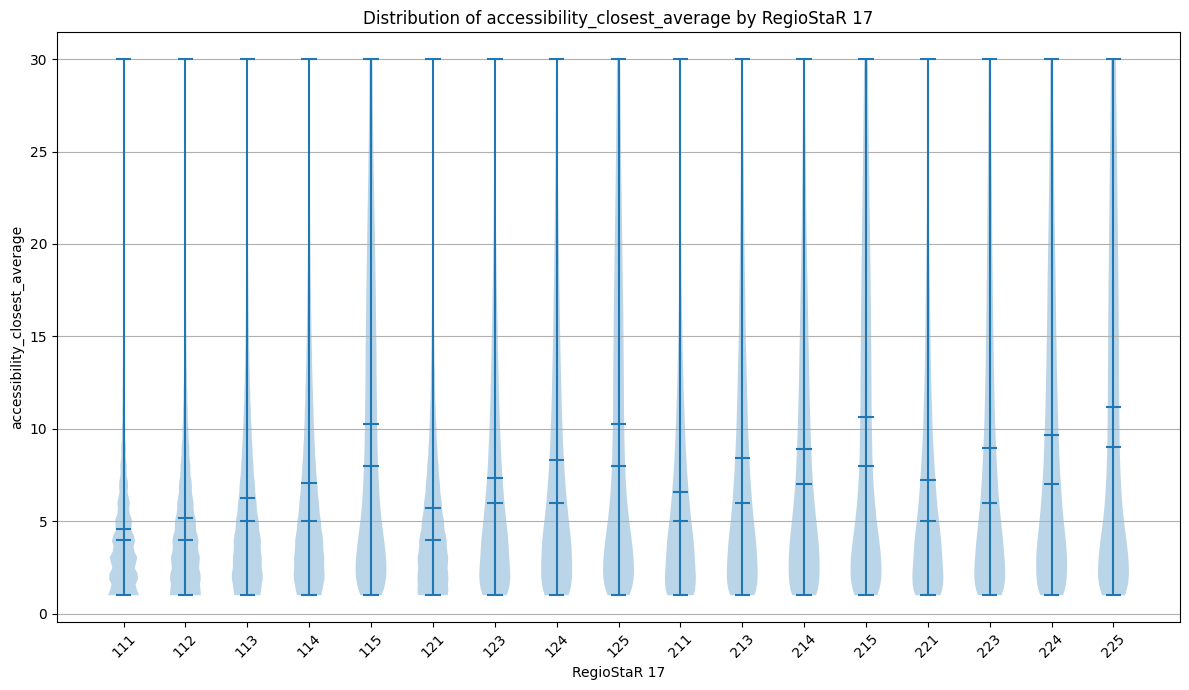

Violin plot generated for accessibility_closest_average by RegioStaR 17


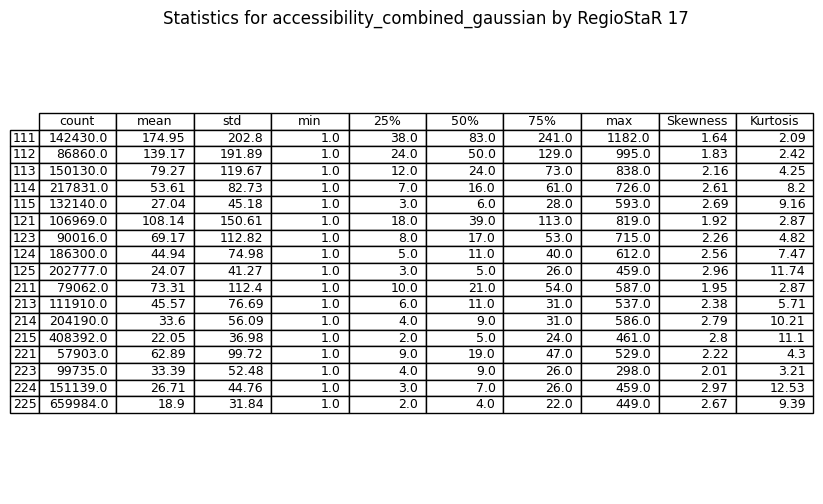

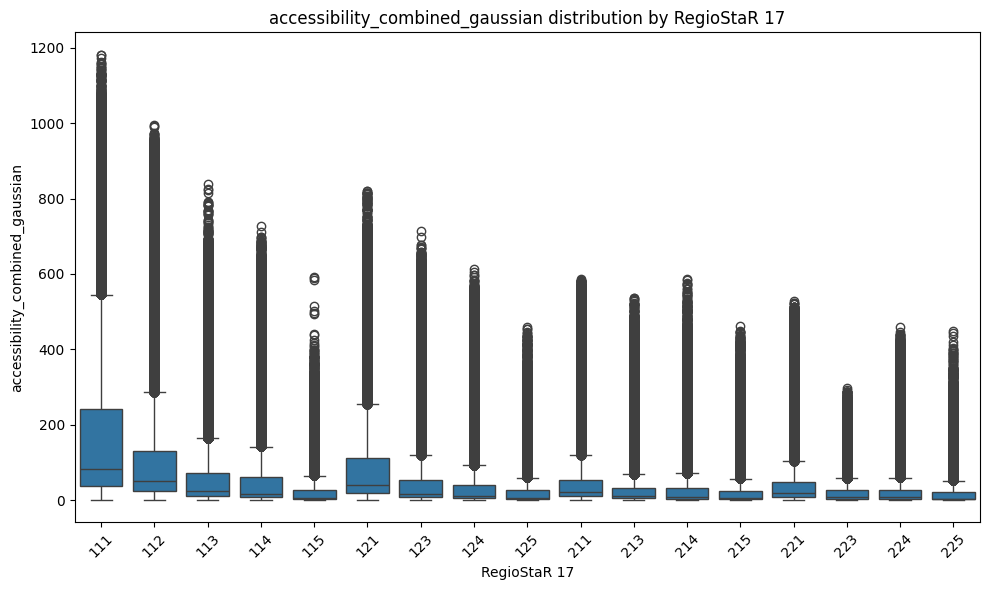

Preparing to plot violin plot for accessibility_combined_gaussian by RegioStaR 17. Valid data lengths: [142430, 86860, 150130, 217831, 132140, 106969, 90016, 186300, 202777, 79062, 111910, 204190, 408392, 57903, 99735, 151139, 659984]


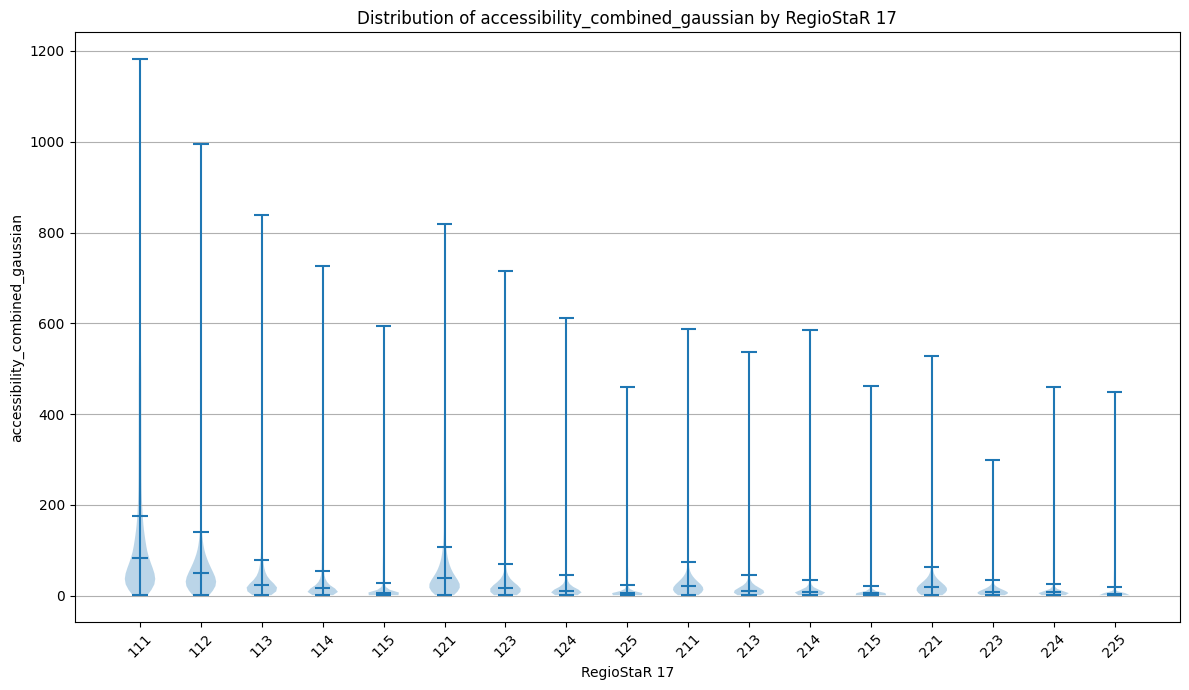

Violin plot generated for accessibility_combined_gaussian by RegioStaR 17


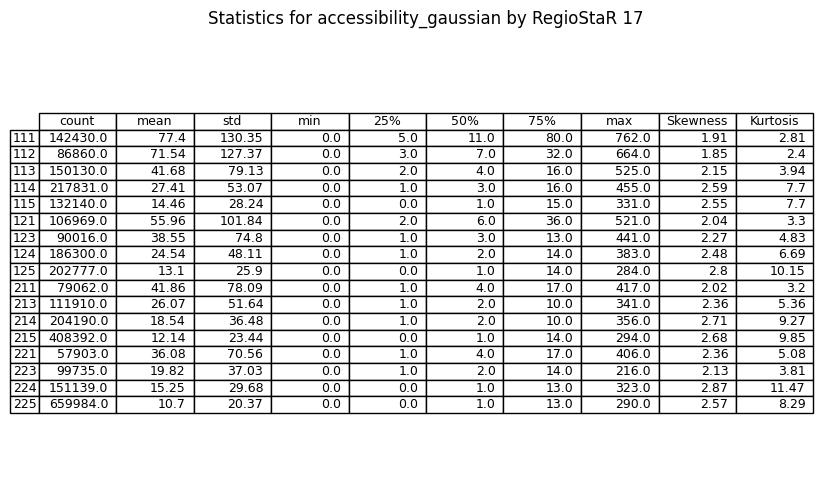

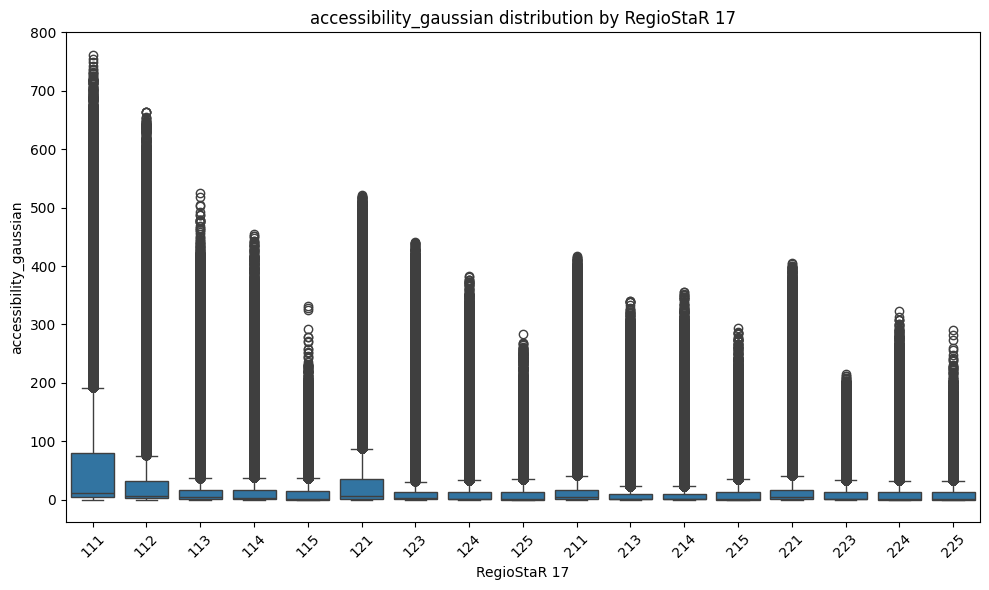

Preparing to plot violin plot for accessibility_gaussian by RegioStaR 17. Valid data lengths: [142430, 86860, 150130, 217831, 132140, 106969, 90016, 186300, 202777, 79062, 111910, 204190, 408392, 57903, 99735, 151139, 659984]


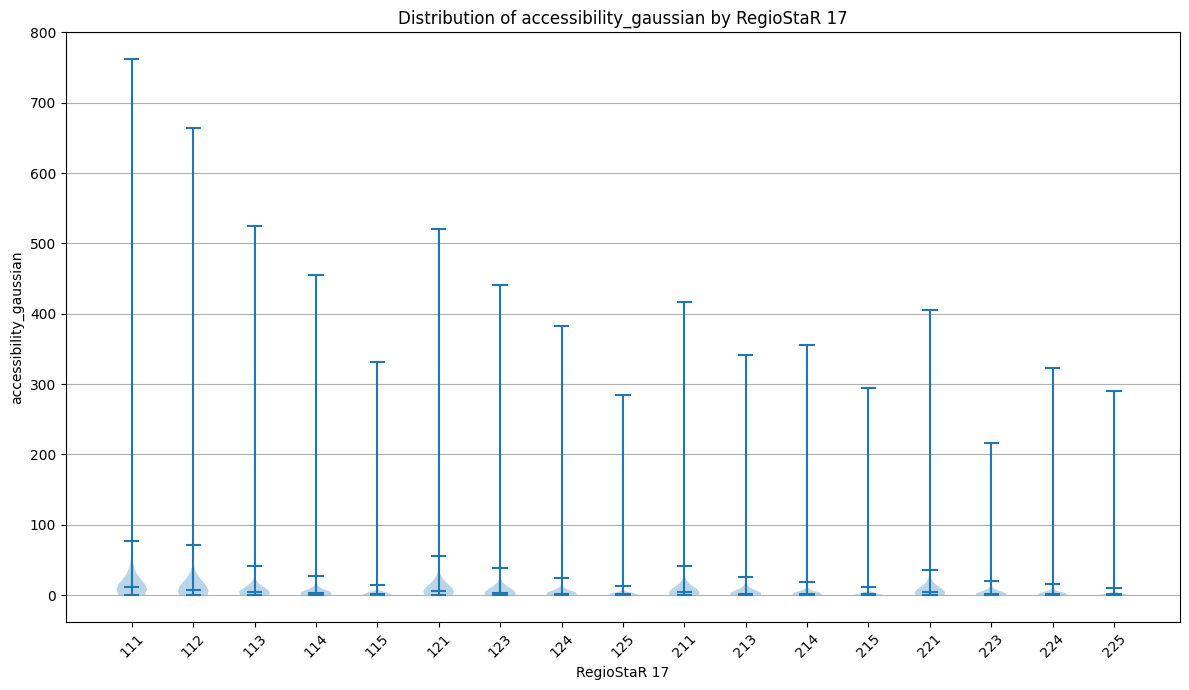

Violin plot generated for accessibility_gaussian by RegioStaR 17


In [28]:
# Initialize EDA class
eda = EDA(db=Database(settings.LOCAL_DATABASE_URI), db_rd=Database(settings.RAW_DATABASE_URI))

# Fetch and optimize the data
poi_category = 'bicycle_immediate' # 'pharmacy'
transport_mode = 'long' # 'bicycle' 
# poi_category = 'pharmacy'
# transport_mode = 'bicycle' 
# df = eda.fetch_data(poi_category, transport_mode)
df = eda.fetch_data_in_chunks(poi_category, transport_mode)

if df.empty:
    print(f"No data available for {poi_category} and {transport_mode}.")
else:
  
    # option to do group plots according to the different regiostar types    
        
    columns_to_exclude = ['h3_index', 'geom', 'objart_txt', 'id']

    exclude_zeros_columns = [col for col in ['population'] if col in df.columns]
    log_y_axis_columns = [col for col in ['population', 'accessibility_combined_gaussian', 'accessibility_gaussian'] if col in df.columns]
    log_x_axis_columns = [col for col in [] if col in df.columns]

    # Perform EDA on the full dataset
    eda.eda_overview(
        df,
        poi_category=poi_category,
        transport_mode=transport_mode,
        columns_to_plot=[col for col in df.select_dtypes(include=[np.number]).columns if col not in columns_to_exclude],
        exclude_zeros_columns=exclude_zeros_columns,
        log_y_axis_columns=log_y_axis_columns,
        log_x_axis_columns=log_x_axis_columns,
        columns_to_exclude=columns_to_exclude,
        plots_to_include=[
            'combined_info',
            'missing_values',
            'histogram',
            'box_plot',
            'correlation_matrix',
            'categorical_counts'
        ],
        exclude_outliers_combined_info = True
    )
    # Clear the dataframe to free memory
    del df
    gc.collect()

In [13]:
# muss ich meine daten cleanen?

# exploratory data analysis
# df.info()
# df.describe()
# df.null().sum()
# df.nunique()
# different plots: scatter, bar, box, hist, heatmap, pairplot, correlation matrix

# discriptive statistics